# **<h1 align="center">Data Mining 2024-25</h3>**
## **<h3 align="center">Customer Segmentation - ABCDEats Inc.</h3>**
### **<h3 align="center">Merging Perpectives</h3>**


**Group 10 members:**<br>Alexandra Pinto - 20211599@novaims.unl.pt - 20211599<br>
Marco Galão  - r20201545@novaims.unl.pt - r20201545<br>
Sven Goerdes - 20240503@novaims.unl.pt - 20240503<br>
Tim Straub  - 20240505@novaims.unl.pt - 20240505<br>

<a id = "toc"></a>

# Table of Contents

* [1. Import the Libraries](#import_libraries)
* [2. Import Data](#import_dataset)
* [3. Final Labels](#final_labels)
* [4. Merging Different Perpectives](#merge_perpectives)
    * [4.1. Contingency Table](#contigency_table)
    * [4.2. Manual Merging of Clusters](#manual_merg_clus)
    * [4.3. Using Hierarchical Clustering](#hierarchical_clust)
* [5. Cluster Analysis](#cluster_analysis)
    * [5.1. Profiling with Demographic features](#profilling_demo)
        * [5.1.1. Customer Region](#cust_region)
        * [5.1.2. Cities](#cities)
        * [5.1.3. Customer Age](#cust_age)
        * [5.1.4. Generation](#generation)
        * [5.1.5. Last Promo](#last_promo)
        * [5.1.6. Promo Used](#promo_used)
        * [5.1.7. Payment Method](#payment_method)
    * [5.2. Cluster Profiling](#cluster_profiling)
        * [5.2.1. Basic Cluster Profile](#basic_cluster)
        * [5.2.2. Heatmap](#heatmap)
        * [5.2.3. Radar Plots](#radar_plots)
    * [5.3. Cluster Visualizations](#cluster_visualization)
* [6. Reclassify Outliers](#reclassify_outliers)
* [7. Exporting Dataset](#exp_data)




---

In this notebook, we will merge the segmentation results from two distinct perspectives: **cuisine preferences** and **customer behavior**. These two perspectives represent different customer behaviors and preferences, and combining them will allow us to develop a more holistic understanding of our customers. 

We will begin by merging the clusters derived from cuisine preference features with those from customer behavior, ensuring that we create a unified dataset with both segmentation labels. Once the merge is completed, we will explore the resulting segments and evaluate their characteristics.

---

# 1. Import the Libraries <a class="anchor" id="import_libraries"></a>
[Back to ToC](#toc)<br>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math
from matplotlib.patches import RegularPolygon, Ellipse
import json
from sklearn.cluster import KMeans
from IPython.display import display, HTML
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier


#To perform Clustering Algorithms
from sklearn.cluster import MeanShift, estimate_bandwidth
# from sklearn_extra.cluster import KMedoids # pip install scikit-learn-extra
from scipy.cluster.hierarchy import dendrogram, linkage
from minisom import MiniSom
from sklearn.metrics import pairwise_distances, euclidean_distances

import warnings
warnings.filterwarnings("ignore")

#Importing the functions created in utils.py
from utils import *
import importlib
imported_module = importlib.import_module("utils")
importlib.reload(imported_module)

<module 'utils' from 'c:\\Users\\xandg\\Ambiente de Trabalho\\IMS\\3rd year\\1st Semester\\Capstone Project\\OpenAI\\Capstone-Project\\CustomerSegmentationDataMining\\deliverables\\utils.py'>

# 2. Import Data <a class="anchor" id="import_dataset"></a>
[Back to ToC](#toc)<br>

In this section, we import the preprocessed dataset and set the customer_id as the index column. Also, check the first and last 5 rows of the dataset.

In [5]:
df_clustering = pd.read_csv("../Data/df_perspectives_labels.csv", index_col="customer_id")
df_clustering.head().T

customer_id,1b8f824d5e,f6d1b2ba63,180c632ed8,4eb37a6705,6aef2b6726
customer_region,2360,4660,4660,4660,8670
customer_age,-1.366137,1.481241,-0.227186,-1.0814,1.765979
vendor_count,-0.404103,-0.77418,-0.404103,-0.404103,-0.404103
product_count,-0.084407,-0.564201,-0.40427,-0.084407,-0.564201
chain_orders,-0.474819,-0.208274,-0.474819,-0.741365,-0.741365
...,...,...,...,...,...
prop_orders_afternoon,-1.069308,-1.069308,0.240297,-1.069308,-1.069308
prop_orders_evening,2.639351,-0.630631,-0.630631,-0.630631,-0.630631
products_per_vendor,0.817727,0.283289,-0.25115,0.817727,-0.785589
cuisine_labels,3,1,3,2,2


Let's open the json file with the categories.

In [6]:
# Load the categories dictionary from the JSON file
with open("perspectives.json", "r") as file:
    loaded_categories = json.load(file)

print("Categories dictionary has been successfully loaded!")
print(loaded_categories)

Categories dictionary has been successfully loaded!
{'customer_behavior': ['prop_chain_orders', 'prop_weekend_orders', 'prop_orders_dawn', 'prop_orders_morning', 'prop_orders_evening', 'first_order', 'order_recency', 'total_cui_spending', 'avg_order_value', 'products_per_vendor'], 'cuisine_preferences': ['prop_cui_cafe', 'prop_cui_chicken dishes', 'prop_cui_chinese', 'prop_cui_desserts', 'prop_cui_healthy', 'prop_cui_indian', 'prop_cui_japanese', 'prop_cui_noodle dishes', 'prop_cui_thai', 'prop_cui_asian_origin', 'prop_cui_western', 'prop_cui_other_origin', 'prop_cui_main_dishes'], 'demographics': ['customer_region', 'city', 'generation', 'customer_age', 'last_promo', 'payment_method', 'promo_used']}


In [7]:
cuisine_preferences = loaded_categories["cuisine_preferences"]
customer_behavior = loaded_categories["customer_behavior"]

For the topic 6. Reclassify Outliers, we will also need to upload the df_outliers.

In [131]:
df_outliers = pd.read_csv("../Data/df_final_outliers.csv", index_col="customer_id")

# 3. Final Labels <a class="anchor" id="final_labels"></a>
[Back to ToC](#toc)<br>

After completing notebooks 02 and 03, we will run the models using the best solution and store the resulting labels to proceed with merging the different perspectives.

> ### Cuisine Preferences
Run kMedoids clustering with 4 clusters and add the cluster labels to the dataframe.

In [341]:
# run kMedoids clustering with 4 clusters and add the cluster labels to the dataframe
kmclust = KMedoids(n_clusters=5, init='k-medoids++', max_iter=300, random_state=42) 
df_clustering['cuisine_labels'] = kmclust.fit_predict(df_clustering[cuisine_preferences])

> ### Customer Behavior
Run kmeans-clustering approach and add the cluster labels to the dataframe.

In [342]:
# kmeans-clustering approach for customer behavior
kmeans_50c = KMeans(n_clusters=50, init='k-means++', n_init=15, random_state=42)
kmeans_labels_50c = kmeans_50c.fit_predict(df_clustering[customer_behavior])
df_centroids_kmeans_50c = pd.DataFrame(kmeans_50c.cluster_centers_, columns=customer_behavior)

In [343]:
# Initialize and fit AgglomerativeClustering for KMeans_Hierarchical clustering
hc = AgglomerativeClustering(n_clusters=4, linkage='ward', metric='euclidean')
cluster_labels = hc.fit_predict(df_centroids_kmeans_50c)

df_centroids_kmeans_50c['behavior_labels'] = cluster_labels

reduced_centroids = df_centroids_kmeans_50c.groupby('behavior_labels').mean()

# Compute distances between each original data point and the reduced centroids
distances = euclidean_distances(df_clustering[customer_behavior], reduced_centroids)

# Assign each data point to the closest reduced centroid
mapped_clusters = np.argmin(distances, axis=1)

# Add the mapped cluster labels to the original dataset
df_clustering['behavior_labels'] = mapped_clusters

Print the dataset with labels.

In [9]:
df_clustering[['behavior_labels', 'cuisine_labels']].head()

,behavior_labels,cuisine_labels
customer_id,,
1b8f824d5e,0,3
f6d1b2ba63,0,1
180c632ed8,0,3
4eb37a6705,3,2
6aef2b6726,2,2


# 4. Merging Different Perpectives <a class="anchor" id="merge_perpectives"></a>
[Back to ToC](#toc)<br>

Now that we have successfully stored our final cluster labels, we can proceed to merge them and determine the final cluster solution.

## 4.1. Contigency Table <a class="anchor" id="contigency_table"></a>
[Back to 4. Merging Different Perpectives](#merge_perpectives)<br>

In [8]:
# Count label frequencies (contigency table)
pd.crosstab(df_clustering['cuisine_labels'],
            df_clustering['behavior_labels'])

behavior_labels,0,1,2,3
cuisine_labels,,,,
0,3086,533,845,860
1,4804,694,442,204
2,7544,1428,2278,857
3,1089,120,17,81
4,5554,510,53,96


In [11]:
total_customers = df_clustering.shape[0]
selected_customers = 500

percentage = (selected_customers / total_customers) * 100
print(f"{selected_customers} customers represent {percentage:.2f}% of the total.")


500 customers represent 1.61% of the total.


As anticipated, we have too many clusters, with several being sparsely populated. To address this, we can reassign these less populated clusters Each with fewer than 500 customers to their closest neighboring clusters.  

This approach involves manual merging, where the lowest frequency clusters are consolidated into the most similar, larger clusters.

In [12]:
# Get centroids of clusters for both taste and purchasing habits
df_centroids = df_clustering.groupby(['cuisine_labels', 'behavior_labels'])[cuisine_preferences + customer_behavior ].mean()
df_centroids

prop_cui_cafe  prop_cui_chicken dishes  \
cuisine_labels behavior_labels                                           
0              0                     0.635799                -0.204340   
               1                     0.788712                -0.246116   
               2                    -0.118353                -0.253249   
               3                    -0.036406                -0.253249   
1              0                    -0.080863                -0.231699   
               1                    -0.028389                -0.246284   
               2                    -0.141285                -0.253249   
               3                    -0.165511                -0.253249   
2              0                    -0.076426                -0.205679   
               1                     0.011401                -0.225201   
               2                    -0.165511                -0.251249   
               3                    -0.159292                -0.253249   
3              0                    -0.131792                -0.184070   
               1                    -0.114717                -0.199314   
               2                    -0.165511                -0.253249   
               3                    -0.165511                -0.253249   
4              0                    -0.093252                 0.966206   
               1                     0.077629                 0.333782   
               2                    -0.145105                 0.594008   
               3                    -0.139683                -0.156869   

                                prop_cui_chinese  prop_cui_desserts  \
cuisine_labels behavior_labels                                        
0              0                       -0.217311           0.659403   
               1                       -0.207726           0.305157   
               2                       -0.247218           0.703900   
               3                       -0.252998           0.473492   
1              0                       -0.241826          -0.163443   
               1                       -0.229843          -0.178671   
               2                       -0.234610          -0.120650   
               3                       -0.257799          -0.159066   
2              0                        0.368968          -0.109820   
               1                        0.174369          -0.062821   
               2                       -0.023397          -0.059307   
               3                        0.022178          -0.131159   
3              0                       -0.225733          -0.174156   
               1                       -0.212163          -0.187486   
               2                       -0.270186          -0.194286   
               3                       -0.270186          -0.194286   
4              0                       -0.003808          -0.127097   
               1                        0.059559          -0.144977   
               2                       -0.119626          -0.181311   
               3                       -0.187207          -0.190344   

                                prop_cui_healthy  prop_cui_indian  \
cuisine_labels behavior_labels                                      
0              0                        0.740926        -0.237497   
               1                        0.623712        -0.251483   
               2                        0.678915        -0.278089   
               3                        0.023313        -0.280506   
1              0                       -0.151326        -0.227796   
               1                       -0.148958        -0.214013   
               2                       -0.141686        -0.273137   
               3                       -0.204096        -0.259571   
2              0                       -0.104615        -0.114160   
               1                       -0.081572        -0.114633   
            

In [13]:
# Minimum cluster size threshold
MIN_CLUSTER_SIZE = 500

# Identify low-frequency clusters
low_freq_clusters = df_clustering.value_counts(['cuisine_labels', 'behavior_labels'])
to_merge = low_freq_clusters[low_freq_clusters < MIN_CLUSTER_SIZE].index.tolist()

In [14]:
print("Centroid Index:")
print(df_centroids.index)
print("Clusters to Merge:")
print(to_merge)

Centroid Index:
MultiIndex([(0, 0),
            (0, 1),
            (0, 2),
            (0, 3),
            (1, 0),
            (1, 1),
            (1, 2),
            (1, 3),
            (2, 0),
            (2, 1),
            (2, 2),
            (2, 3),
            (3, 0),
            (3, 1),
            (3, 2),
            (3, 3),
            (4, 0),
            (4, 1),
            (4, 2),
            (4, 3)],
           names=['cuisine_labels', 'behavior_labels'])
Clusters to Merge:
[(1, 2), (1, 3), (3, 1), (4, 3), (3, 3), (4, 2), (3, 2)]


In [15]:
# Filter clusters to merge based on available centroids
valid_to_merge = [clus for clus in to_merge if clus in df_centroids.index]

# Compute pairwise Euclidean distances between centroids
centroid_dists = pairwise_distances(df_centroids)
df_dists = pd.DataFrame(
    centroid_dists,
    columns=df_centroids.index,
    index=df_centroids.index
)

# Iteratively merge low-frequency clusters
df_ = df_clustering.copy()

while valid_to_merge:
    # Map each low-frequency cluster to its nearest valid neighbor
    source_target = {}
    valid_targets = [
        clus for clus in df_centroids.index 
        if clus not in valid_to_merge  # Exclude low-frequency clusters as targets
    ]

    for clus in valid_to_merge:
        # If the cluster has not already been used as a target, proceed
        if clus not in source_target.values() and valid_targets:
            # Find the closest valid target cluster
            closest_target = (
                df_dists.loc[clus, valid_targets]
                .sort_values()
                .index[0]
            )
            source_target[clus] = closest_target

    # Apply the source-to-target mappings to the dataset
    for source, target in source_target.items():
        # Create a mask for the rows belonging to the source cluster
        mask = (df_['cuisine_labels'] == source[0]) & (df_['behavior_labels'] == source[1])
        # Reassign rows to the target cluster
        df_.loc[mask, 'cuisine_labels'] = target[0]
        df_.loc[mask, 'behavior_labels'] = target[1]

    # Update cluster centroids after reassignment
    # Recalculate centroids if needed (not shown here, assuming it's done elsewhere)

    # Recompute low-frequency clusters
    low_freq_clusters = df_.value_counts(['cuisine_labels', 'behavior_labels'])
    valid_to_merge = low_freq_clusters[low_freq_clusters < MIN_CLUSTER_SIZE].index.tolist()
    valid_to_merge = [clus for clus in valid_to_merge if clus in df_centroids.index]

# Generate the final contingency table
final_contingency_table = pd.crosstab(df_['cuisine_labels'], df_['behavior_labels'])

#Validate that all clusters meet the size threshold
final_cluster_sizes = df_.value_counts(['cuisine_labels', 'behavior_labels'])
assert all(final_cluster_sizes >= MIN_CLUSTER_SIZE), "Some clusters still have less than the minimum size!"

Let's check the changes by comparing both contingency tables.

In [22]:
# Generate the tables as HTML
final_contingency_html = final_contingency_table.to_html()
original_contingency_html = pd.crosstab(df_clustering['cuisine_labels'], df_clustering['behavior_labels']).to_html()

# Combine the two tables into a single centered HTML block
centered_html = f"""
<div style="display: flex; justify-content: center; align-items: flex-start; gap: 40px;">
    <div>
        <h3>Original Contingency Table:</h3>
        {original_contingency_html}
    </div>
    <div>
        <h3>Final Contingency Table After Merging:</h3>
        {final_contingency_html}
    </div>
</div>
"""

# Display the HTML
display(HTML(centered_html))

behavior_labels,0,1,2,3
cuisine_labels,,,,
0,3086,533,845,860
1,4804,694,442,204
2,7544,1428,2278,857
3,1089,120,17,81
4,5554,510,53,96
behavior_labels,0,1,2,3
cuisine_labels,,,,
0,3086,533,845,860
1,5008,694,0,0


## 4.2. Using Hierarchical Clustering <a class="anchor" id="hierarchical_clust"></a>
[Back to 4. Merging Different Perpectives](#merge_perpectives)<br>

In [138]:
# Get centroids of clusters for both cuisine and behavior labels
df_centroids = df_clustering.groupby(['cuisine_labels', 'behavior_labels'])[cuisine_preferences + customer_behavior].mean()
df_centroids

prop_cui_cafe  prop_cui_chicken dishes  \
cuisine_labels behavior_labels                                           
0              0                     0.635799                -0.204340   
               1                     0.788712                -0.246116   
               2                    -0.118353                -0.253249   
               3                    -0.036406                -0.253249   
1              0                    -0.080863                -0.231699   
               1                    -0.028389                -0.246284   
               2                    -0.141285                -0.253249   
               3                    -0.165511                -0.253249   
2              0                    -0.076426                -0.205679   
               1                     0.011401                -0.225201   
               2                    -0.165511                -0.251249   
               3                    -0.159292                -0.253249   
3              0                    -0.131792                -0.184070   
               1                    -0.114717                -0.199314   
               2                    -0.165511                -0.253249   
               3                    -0.165511                -0.253249   
4              0                    -0.093252                 0.966206   
               1                     0.077629                 0.333782   
               2                    -0.145105                 0.594008   
               3                    -0.139683                -0.156869   

                                prop_cui_chinese  prop_cui_desserts  \
cuisine_labels behavior_labels                                        
0              0                       -0.217311           0.659403   
               1                       -0.207726           0.305157   
               2                       -0.247218           0.703900   
               3                       -0.252998           0.473492   
1              0                       -0.241826          -0.163443   
               1                       -0.229843          -0.178671   
               2                       -0.234610          -0.120650   
               3                       -0.257799          -0.159066   
2              0                        0.368968          -0.109820   
               1                        0.174369          -0.062821   
               2                       -0.023397          -0.059307   
               3                        0.022178          -0.131159   
3              0                       -0.225733          -0.174156   
               1                       -0.212163          -0.187486   
               2                       -0.270186          -0.194286   
               3                       -0.270186          -0.194286   
4              0                       -0.003808          -0.127097   
               1                        0.059559          -0.144977   
               2                       -0.119626          -0.181311   
               3                       -0.187207          -0.190344   

                                prop_cui_healthy  prop_cui_indian  \
cuisine_labels behavior_labels                                      
0              0                        0.740926        -0.237497   
               1                        0.623712        -0.251483   
               2                        0.678915        -0.278089   
               3                        0.023313        -0.280506   
1              0                       -0.151326        -0.227796   
               1                       -0.148958        -0.214013   
               2                       -0.141686        -0.273137   
               3                       -0.204096        -0.259571   
2              0                       -0.104615        -0.114160   
               1                       -0.081572        -0.114633   
            

The next step involves using hierarchical clustering to merge the concatenated cluster centroids and determine the optimal number of clusters for the final solution.

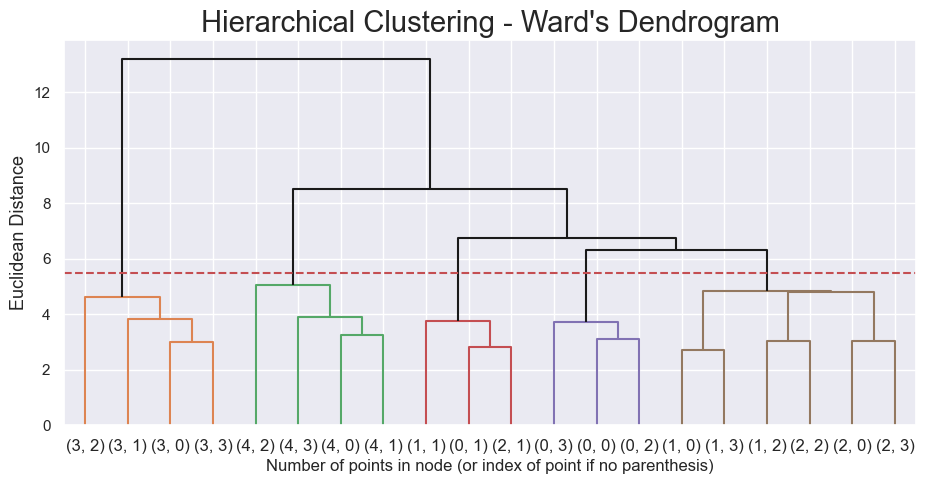

In [141]:
# Using Hierarchical clustering to merge the concatenated cluster centroids
linkage = 'ward'
hclust = AgglomerativeClustering(linkage=linkage, metric='euclidean', distance_threshold=0, n_clusters=None)

hclust_labels = hclust.fit_predict(df_centroids)

# Create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

for i, merge in enumerate(hclust.children_):
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1  # leaf node
        else:
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# The linkage matrix
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11, 5))
y_threshold = 5.5

dendrogram(linkage_matrix, 
           labels=df_centroids.index, 
           color_threshold=y_threshold, 
           above_threshold_color='k')


plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'Euclidean Distance', fontsize=13)
plt.show()


In [142]:
# Re-running the Hierarchical clustering based on the correct number of clusters
hclust = AgglomerativeClustering(linkage='ward', metric='euclidean', n_clusters=5)
hclust_labels = hclust.fit_predict(df_centroids)
df_centroids['hclust_labels'] = hclust_labels

df_centroids

prop_cui_cafe  prop_cui_chicken dishes  \
cuisine_labels behavior_labels                                           
0              0                     0.635799                -0.204340   
               1                     0.788712                -0.246116   
               2                    -0.118353                -0.253249   
               3                    -0.036406                -0.253249   
1              0                    -0.080863                -0.231699   
               1                    -0.028389                -0.246284   
               2                    -0.141285                -0.253249   
               3                    -0.165511                -0.253249   
2              0                    -0.076426                -0.205679   
               1                     0.011401                -0.225201   
               2                    -0.165511                -0.251249   
               3                    -0.159292                -0.253249   
3              0                    -0.131792                -0.184070   
               1                    -0.114717                -0.199314   
               2                    -0.165511                -0.253249   
               3                    -0.165511                -0.253249   
4              0                    -0.093252                 0.966206   
               1                     0.077629                 0.333782   
               2                    -0.145105                 0.594008   
               3                    -0.139683                -0.156869   

                                prop_cui_chinese  prop_cui_desserts  \
cuisine_labels behavior_labels                                        
0              0                       -0.217311           0.659403   
               1                       -0.207726           0.305157   
               2                       -0.247218           0.703900   
               3                       -0.252998           0.473492   
1              0                       -0.241826          -0.163443   
               1                       -0.229843          -0.178671   
               2                       -0.234610          -0.120650   
               3                       -0.257799          -0.159066   
2              0                        0.368968          -0.109820   
               1                        0.174369          -0.062821   
               2                       -0.023397          -0.059307   
               3                        0.022178          -0.131159   
3              0                       -0.225733          -0.174156   
               1                       -0.212163          -0.187486   
               2                       -0.270186          -0.194286   
               3                       -0.270186          -0.194286   
4              0                       -0.003808          -0.127097   
               1                        0.059559          -0.144977   
               2                       -0.119626          -0.181311   
               3                       -0.187207          -0.190344   

                                prop_cui_healthy  prop_cui_indian  \
cuisine_labels behavior_labels                                      
0              0                        0.740926        -0.237497   
               1                        0.623712        -0.251483   
               2                        0.678915        -0.278089   
               3                        0.023313        -0.280506   
1              0                       -0.151326        -0.227796   
               1                       -0.148958        -0.214013   
               2                       -0.141686        -0.273137   
               3                       -0.204096        -0.259571   
2              0                       -0.104615        -0.114160   
               1                       -0.081572        -0.114633   
            

In [143]:
# Mapper between concatenated clusters and hierarchical clusters
cluster_mapper = df_centroids['hclust_labels'].to_dict()
cluster_mapper

{(0, 0): 4,
 (0, 1): 3,
 (0, 2): 4,
 (0, 3): 4,
 (1, 0): 2,
 (1, 1): 3,
 (1, 2): 2,
 (1, 3): 2,
 (2, 0): 2,
 (2, 1): 3,
 (2, 2): 2,
 (2, 3): 2,
 (3, 0): 1,
 (3, 1): 1,
 (3, 2): 1,
 (3, 3): 1,
 (4, 0): 0,
 (4, 1): 0,
 (4, 2): 0,
 (4, 3): 0}

In [145]:
df_ = df_clustering.copy()

# Mapping the hierarchical clusters on the centroids to the observations
df_['merged_labels'] = df_.apply(
    lambda row: cluster_mapper[
        (row['cuisine_labels'], row['behavior_labels'])
    ], axis=1
)

df_ [['cuisine_labels', 'behavior_labels', 'merged_labels']].head()

,cuisine_labels,behavior_labels,merged_labels
customer_id,,,
1b8f824d5e,3,0,1
f6d1b2ba63,1,0,2
180c632ed8,3,0,1
4eb37a6705,2,3,2
6aef2b6726,2,2,2


# 5. Cluster Analysis <a class="anchor" id="cluster_analysis"></a>
[Back to ToC](#toc)<br>

With the merged labels finalized, we can now begin the cluster analysis. In this section, we will examine key statistics, generate insightful plots, and delve deeper into the general behavior of each cluster.

In [146]:
# Merged cluster centroids
df_.groupby('merged_labels').mean(numeric_only=True)[cuisine_preferences + customer_behavior].T

merged_labels,0,1,2,3,4
prop_cui_cafe,-0.080385,-0.132753,-0.097637,0.157048,0.382125
prop_cui_chicken dishes,0.893765,-0.190657,-0.224298,-0.234911,-0.221745
prop_cui_chinese,-0.002429,-0.227820,0.088733,-0.007996,-0.228992
prop_cui_desserts,-0.130005,-0.176890,-0.120711,-0.019230,0.633880
prop_cui_healthy,-0.120553,-0.161515,-0.126028,0.042402,0.601175
prop_cui_indian,-0.156411,4.304722,-0.185944,-0.168084,-0.252377
prop_cui_japanese,-0.230521,-0.315412,0.196529,0.053523,-0.306294
prop_cui_noodle dishes,0.762208,-0.179729,-0.190921,-0.193796,-0.189272
prop_cui_thai,-0.091763,-0.120741,0.100880,0.010577,-0.193537
prop_cui_asian_origin,-0.662179,1.198315,0.384358,0.100261,-0.817694


We will also use the inverse scaler to create a dataset without scaling. This approach allows us to better understand how demographic features and other attributes behave across the different `merged_labels`.

In [147]:
df_profiling = df_clustering.copy()

# Mapping the hierarchical clusters on the centroids to the observations
df_profiling['merged_labels'] = df_profiling.apply(
    lambda row: cluster_mapper[
        (row['cuisine_labels'], row['behavior_labels'])
    ], axis=1
)

df_profiling 

,customer_region,customer_age,vendor_count,product_count,chain_orders,first_order,last_order,last_promo,payment_method,CUI_American,...,prop_weekend_orders,prop_weekday_orders,prop_orders_dawn,prop_orders_morning,prop_orders_afternoon,prop_orders_evening,products_per_vendor,cuisine_labels,behavior_labels,merged_labels
customer_id,,,,,,,,,,,,,,,,,,,,,
1b8f824d5e,2360,-1.366137,-0.404103,-0.084407,-0.474819,-1.178442,-2.703786,DELIVERY,DIGI,-0.432862,...,2.267870,-2.267870,-0.433757,-0.796953,-1.069308,2.639351,0.817727,3,0,1
f6d1b2ba63,4660,1.481241,-0.774180,-0.564201,-0.208274,-1.178442,-2.703786,DISCOUNT,CASH,0.395749,...,2.267870,-2.267870,-0.433757,2.132628,-1.069308,-0.630631,0.283289,1,0,2
180c632ed8,4660,-0.227186,-0.404103,-0.404270,-0.474819,-1.178442,-2.660642,DELIVERY,DIGI,-0.432862,...,0.669937,-0.669937,-0.433757,0.667837,0.240297,-0.630631,-0.251150,3,0,1
4eb37a6705,4660,-1.081400,-0.404103,-0.084407,-0.741365,-1.178442,-2.660642,NOPROMO,DIGI,0.879406,...,0.669937,-0.669937,-0.433757,2.132628,-1.069308,-0.630631,0.817727,2,3,2
6aef2b6726,8670,1.765979,-0.404103,-0.564201,-0.741365,-1.178442,-2.660642,FREEBIE,DIGI,-0.432862,...,0.669937,-0.669937,3.307340,-0.796953,-1.069308,-0.630631,-0.785589,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
f4e366c281,8670,0.342290,-0.774180,-0.724132,-0.474819,-1.178442,-2.746929,FREEBIE,DIGI,-0.432862,...,2.267870,-2.267870,-0.433757,-0.796953,1.549902,-0.630631,-0.785589,0,0,4
f6b6709018,8670,-0.227186,-0.774180,-0.724132,-0.741365,-1.178442,-2.746929,DELIVERY,DIGI,1.191936,...,2.267870,-2.267870,-0.433757,-0.796953,1.549902,-0.630631,-0.785589,1,0,2
f74ad8ce3f,8670,-0.511924,-0.774180,-0.724132,-0.474819,-1.178442,-2.746929,NOPROMO,DIGI,-0.432862,...,2.267870,-2.267870,3.307340,-0.796953,-1.069308,-0.630631,-0.785589,0,2,4


In [148]:
metric_features = df_profiling.select_dtypes(include=['number']).columns.tolist()

In [149]:
# exclude the following columns from the metric_features list: 'behavior_labels','city','cuisine_labels','customer_region','merged_labels'
metric_features = [feature for feature in metric_features if feature not in ['behavior_labels','city','cuisine_labels','customer_region','merged_labels']]

In [150]:
df_profiling_unscaled = df_profiling.copy()

# import the pickle file with the standard scaler
import pickle
scaler = pickle.load(open('../Data/scaler.pkl', "rb"))

# Apply  inverse scaling on the dataframe and give it back as the original dataframe
df_profiling_unscaled[metric_features] = scaler.inverse_transform(df_profiling_unscaled[metric_features])

## 5.1. Profiling with Demographic features  <a class="anchor" id="profilling_demo"></a>
[Back to 5. Cluster Analysis](#cluster_analysis)<br>

In this section, we will examine the demographic features to gain deeper insights and effectively categorize our final cluster solution.

In [151]:
# Ensure that loaded_categories['demographics'] and loaded_categories['categorical'] are valid lists of column names
demographics = loaded_categories['demographics']

# Apply mode() and handle the case of multiple modes per group for combined columns
mode_df = df_profiling_unscaled.groupby('merged_labels')[demographics].agg(lambda x: x.mode().iloc[0]).T

mode_df

merged_labels,0,1,2,3,4
customer_region,2360,4660,8670,4660,8670
city,2,4,8,4,8
generation,Millennials,Millennials,Millennials,Millennials,Millennials
customer_age,26.0,26.0,26.0,26.0,26.0
last_promo,NOPROMO,NOPROMO,NOPROMO,NOPROMO,NOPROMO
payment_method,CARD,CARD,CARD,CARD,CARD
promo_used,0.0,1.0,0.0,0.0,1.0


By analyzing the mode, we observe that certain features, such as generation, customer age, last promotion used, and payment method, remain consistent across different clusters. Despite this, we will create visualizations to better understand the distribution of demographic features across the final cluster labels.

### 5.1.1. Customer Region <a class="anchor" id="cust_region"></a>
[Back to 5.1. Profiling with Demographic features](#profilling_demo)<br>

Let's start plotting customer region.

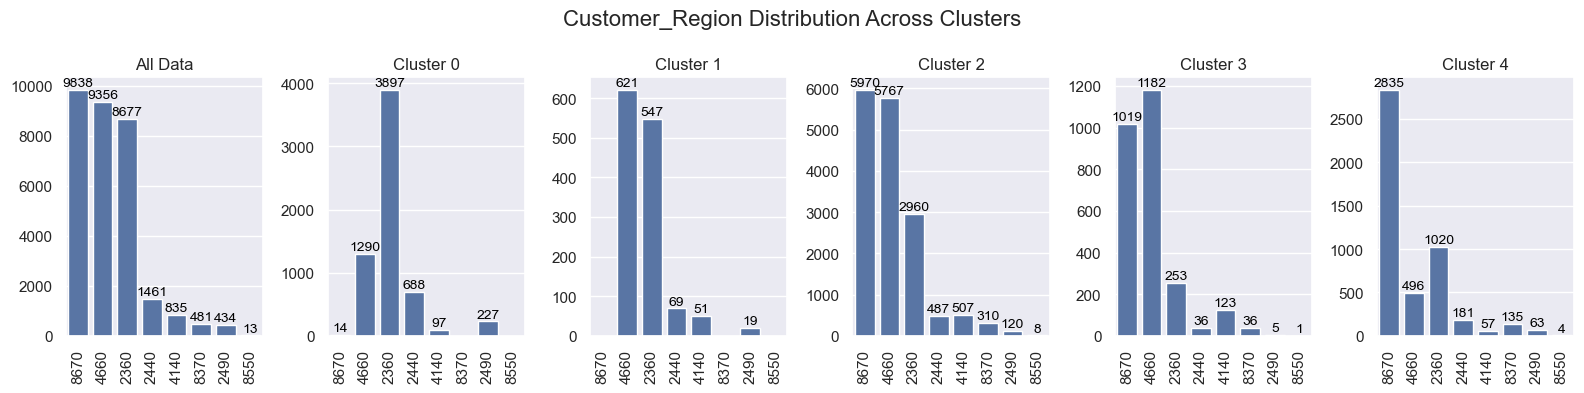

In [152]:
plot_demographics_distribution(df_profiling_unscaled,'customer_region')

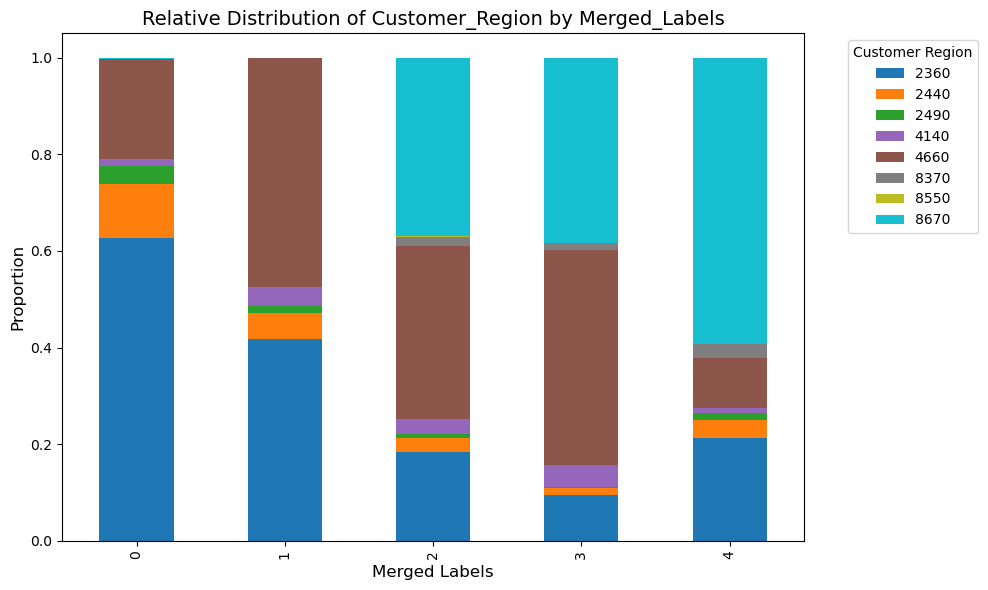

In [34]:
plot_demographics_relative_distribution(df_profiling_unscaled, 'customer_region')

### 5.1.2. Cities <a class="anchor" id="cities"></a>
[Back to 5.1. Profiling with Demographic features](#profilling_demo)<br>

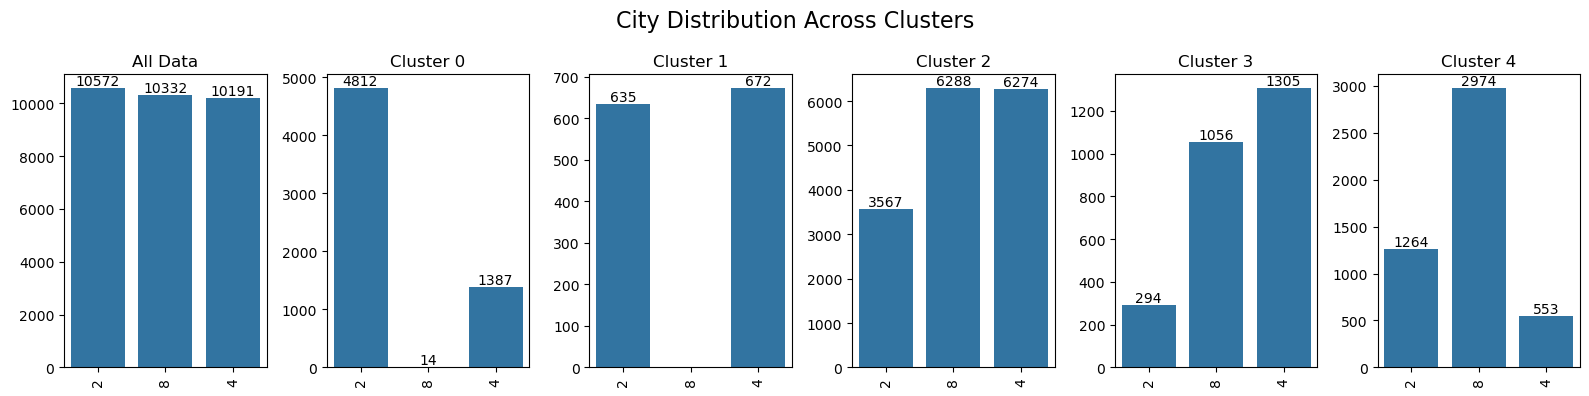

In [35]:
plot_demographics_distribution(df_profiling_unscaled, 'city')

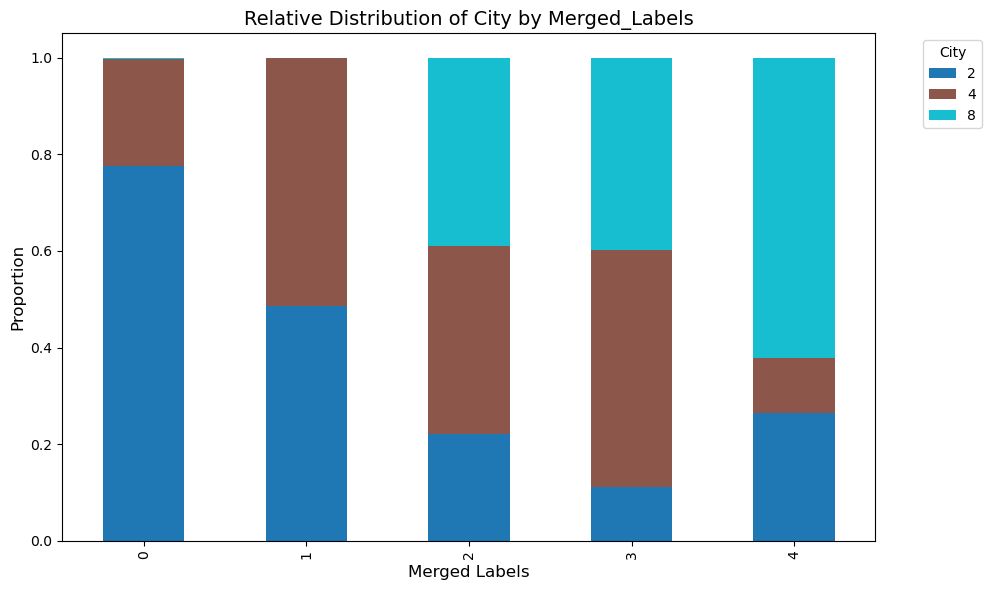

In [36]:
plot_demographics_relative_distribution(df_profiling_unscaled, 'city')

As observed in the customer_region plots, clusters 0 and 1 do not include any customers from city 2. In other words, these clusters lack customers residing in regions 2360, 2440, and 2490.

### 5.1.3. Customer Age <a class="anchor" id="cust_age"></a>
[Back to 5.1. Profiling with Demographic features](#profilling_demo)<br>

When analyzing the mode, we observed that all clusters share the same mode. However, for a more detailed analysis, we can also examine the age distribution across clusters.

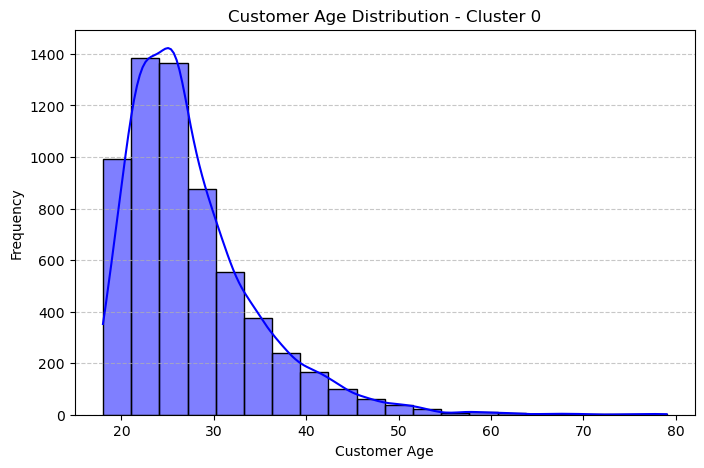

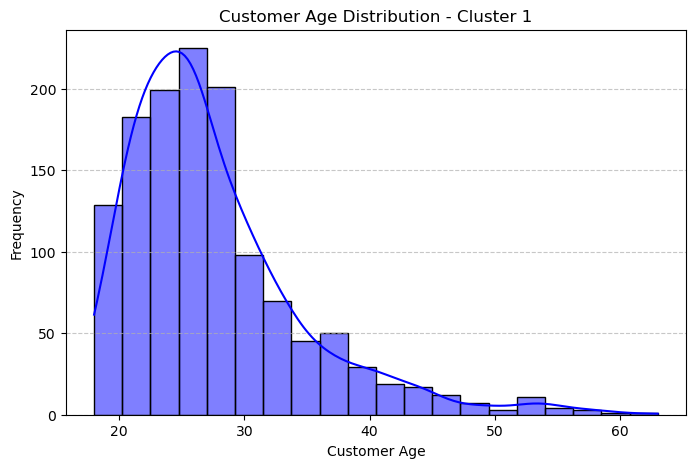

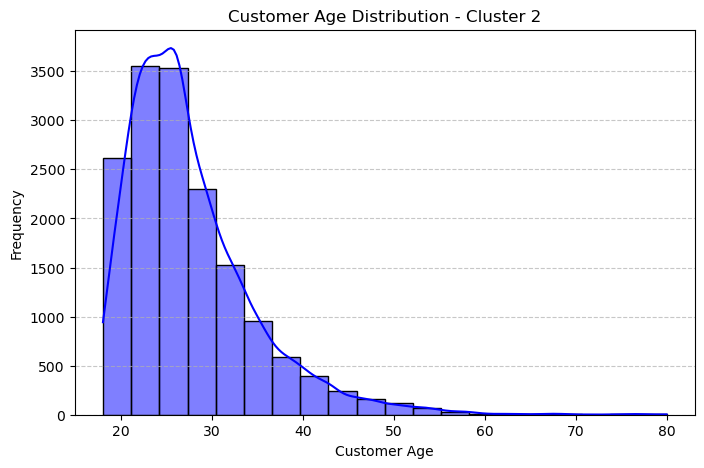

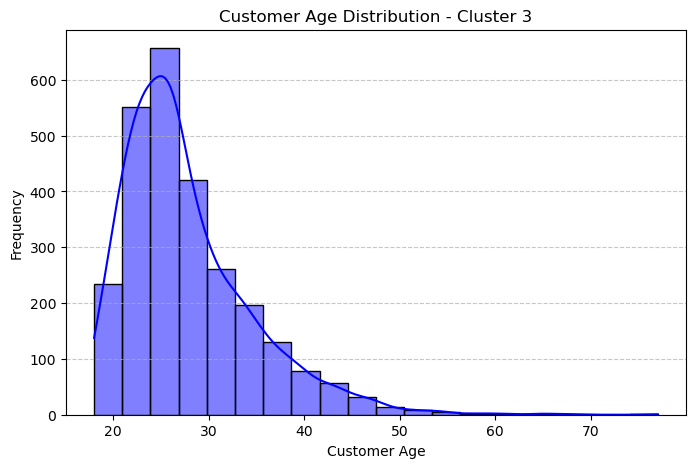

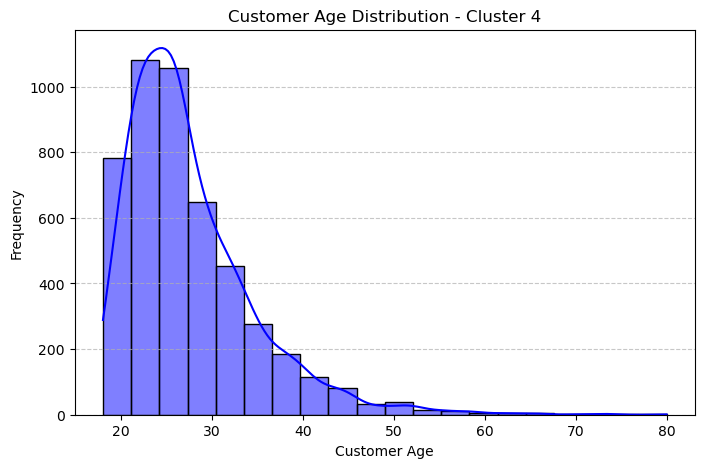

In [37]:
plot_customer_age_distribution(df_profiling_unscaled)

We can also check the quantiles of customer_age per merged_labels with additional quantiles


In [43]:
quantiles = (
    df_profiling_unscaled.groupby('merged_labels')['customer_age']
    .quantile([0, 0.1, 0.25, 0.5, 0.75, 0.9, 1])
    .unstack()
)

# Rename the columns for better readability
quantiles.columns = ['Min',
    '10th Percentile', '25th Percentile', 'Median (50th Percentile)', 
    '75th Percentile', '90th Percentile', 'Max Value'
]

# Display the quantiles
quantiles


,Min,10th Percentile,25th Percentile,Median (50th Percentile),75th Percentile,90th Percentile,Max Value
merged_labels,,,,,,,
0,18.0,21.0,23.0,26.0,31.0,37.0,79.0
1,18.0,21.0,23.0,26.0,30.0,37.0,63.0
2,18.0,21.0,23.0,26.0,31.0,37.0,80.0
3,18.0,21.0,23.0,26.0,31.0,37.0,77.0
4,18.0,20.0,23.0,26.0,31.0,37.0,80.0


The age distribution across all clusters is notably left-skewed. When analyzing different quantiles, the distribution appears consistent and well-distributed among clusters. However, the maximum age differs significantly between clusters. For instance, in cluster 1, the maximum age is 63, while in clusters 2 and 4, it reaches 80 years. This variation in maximum values highlights slight demographic differences between clusters.

### 5.1.4. Generation <a class="anchor" id="generation"></a>
[Back to 5.1. Profiling with Demographic features](#profilling_demo)<br>

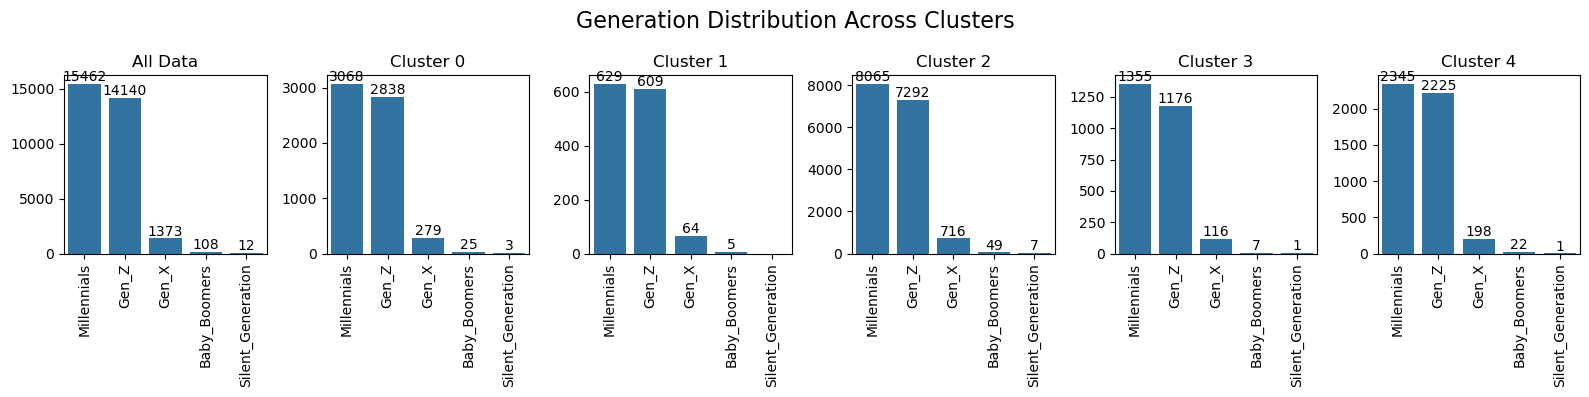

In [44]:
plot_demographics_distribution(df_profiling_unscaled, 'generation')

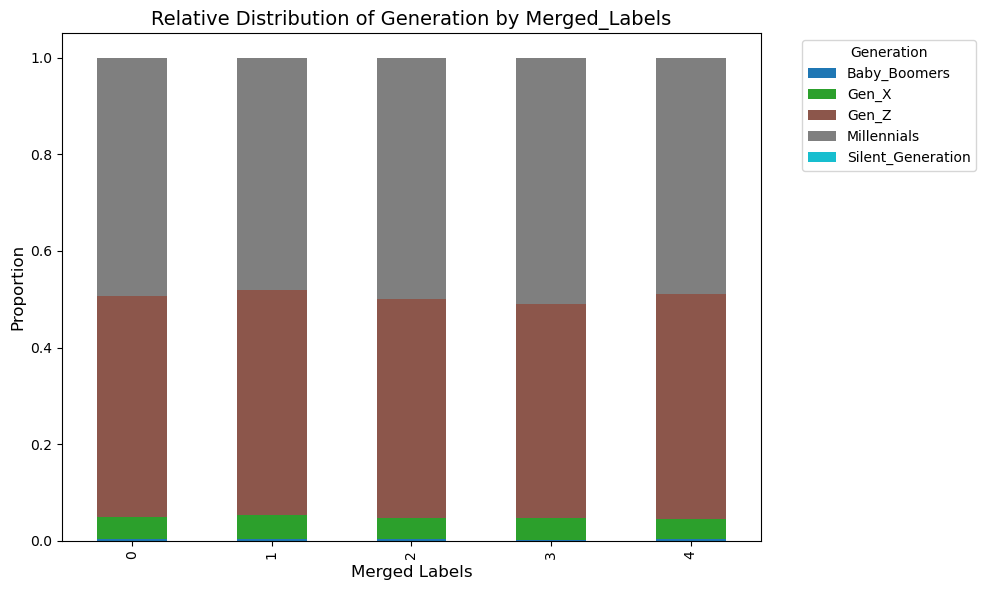

In [45]:
plot_demographics_relative_distribution(df_profiling_unscaled, 'generation')

As anticipated from the analysis of customer age, the generational distribution does not vary significantly across clusters. However, cluster 1 stands out as the only cluster without any customers from the Silent Generation and has fewer Baby Boomers compared to the other clusters.

### 5.1.5. Last Promo <a class="anchor" id="last_promo"></a>
[Back to 5.1. Profiling with Demographic features](#profilling_demo)<br>

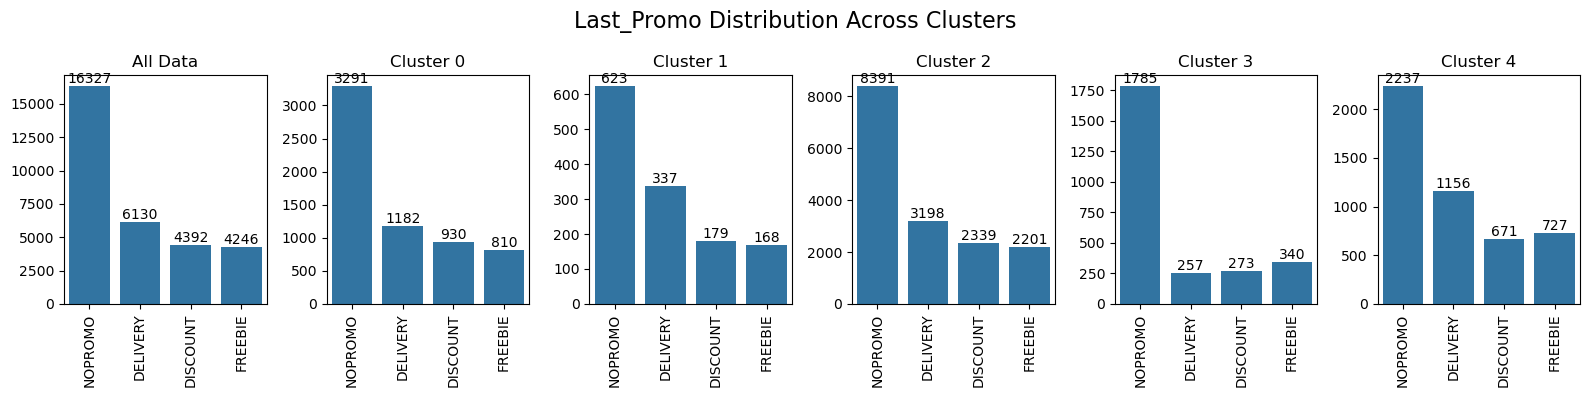

In [46]:
plot_demographics_distribution(df_profiling_unscaled, "last_promo")

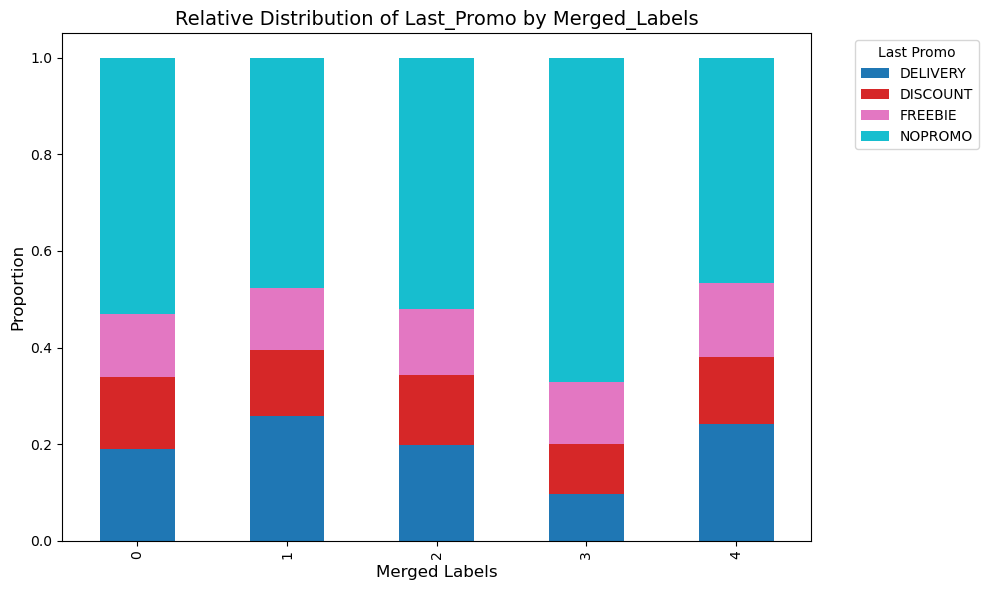

In [47]:
plot_demographics_relative_distribution(df_profiling_unscaled, "last_promo")

### 5.1.6. Promo Used <a class="anchor" id="promo_used"></a>
[Back to 5.2. Profiling with Demographic features](#profilling_demo)<br>

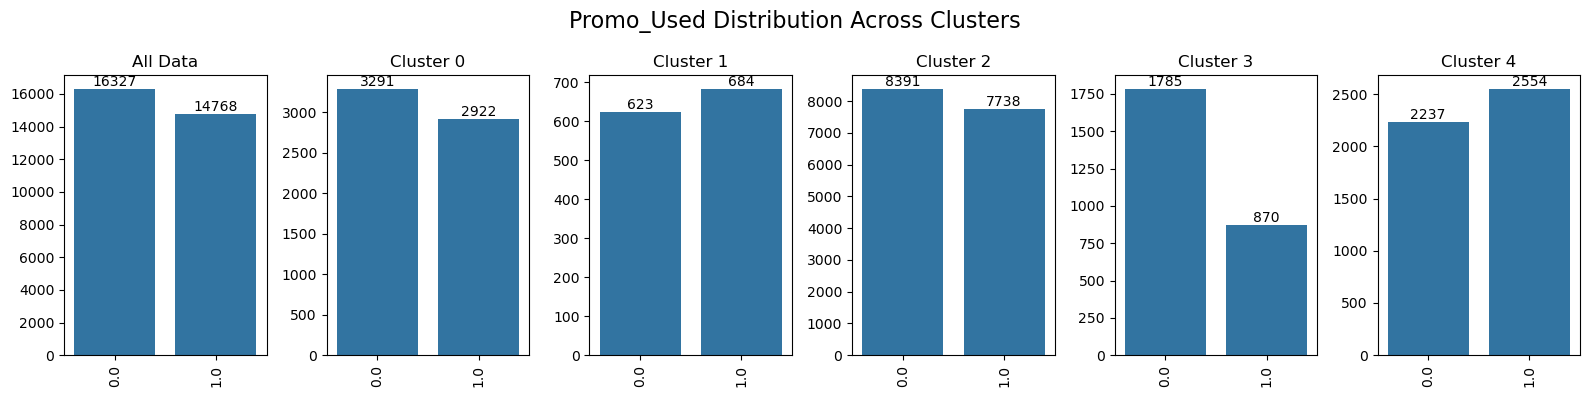

In [48]:
plot_demographics_distribution(df_profiling_unscaled, "promo_used")

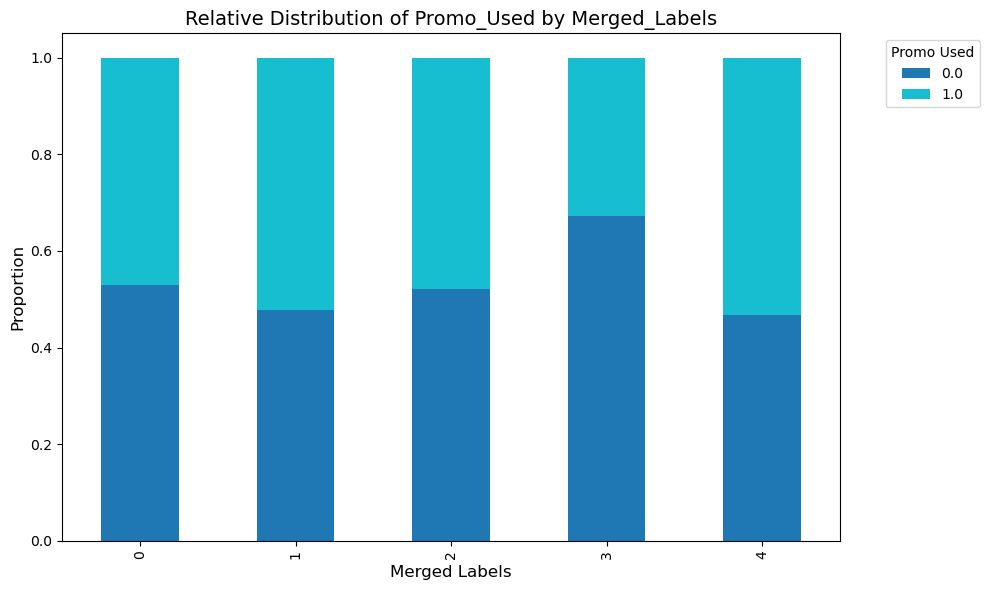

In [49]:
plot_demographics_relative_distribution(df_profiling_unscaled, "promo_used")

### 5.1.7. Payment Method <a class="anchor" id="payment_method"></a>
[Back to 5.1. Profiling with Demographic features](#profilling_demo)<br>

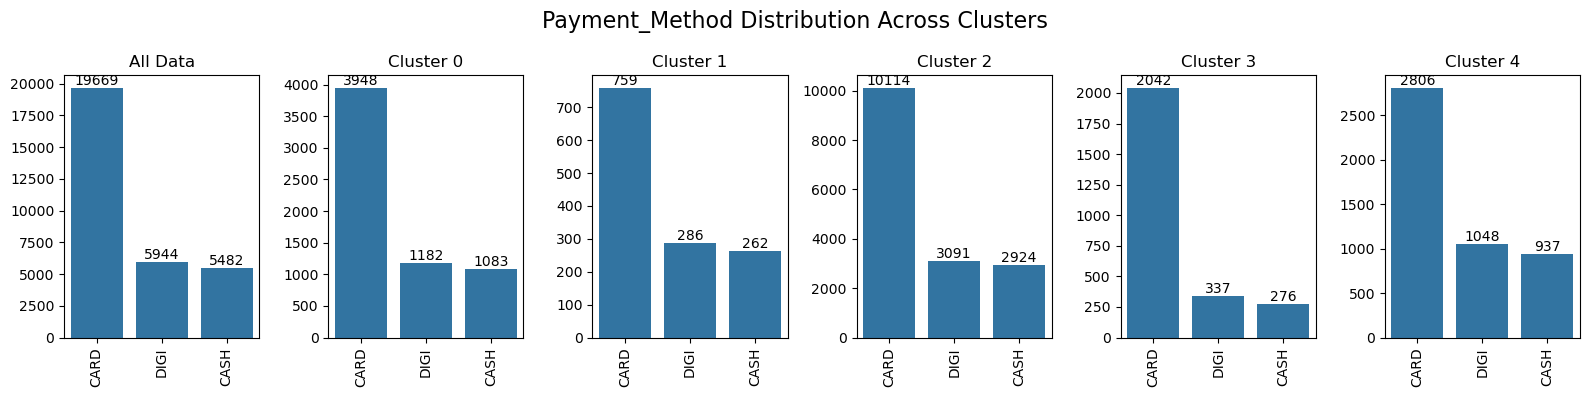

In [50]:
plot_demographics_distribution(df_profiling_unscaled, "payment_method")

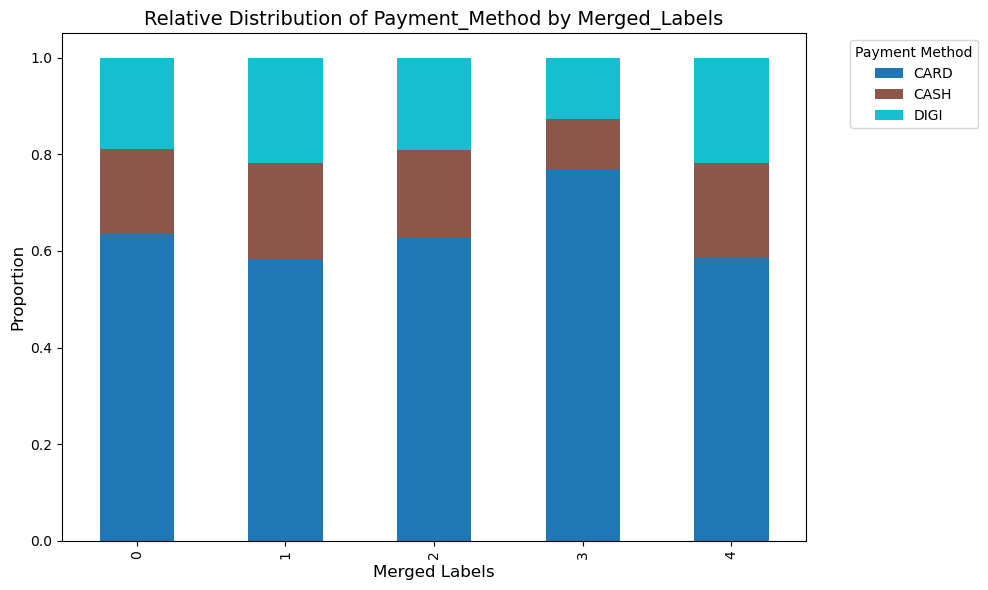

In [51]:
plot_demographics_relative_distribution(df_profiling_unscaled, "payment_method")

## 5.2. Cluster Profiling <a class="anchor" id="cluster_profiling"></a>
[Back to 5. Cluster Analysis](#cluster_analysis)<br>

### 5.2.1. Basic Cluster Profile <a class="anchor" id="basic_cluster"></a>
[Back to 5.2. Cluster Profiling](#cluster_profiling)<br>

Let's start profiling each cluster.

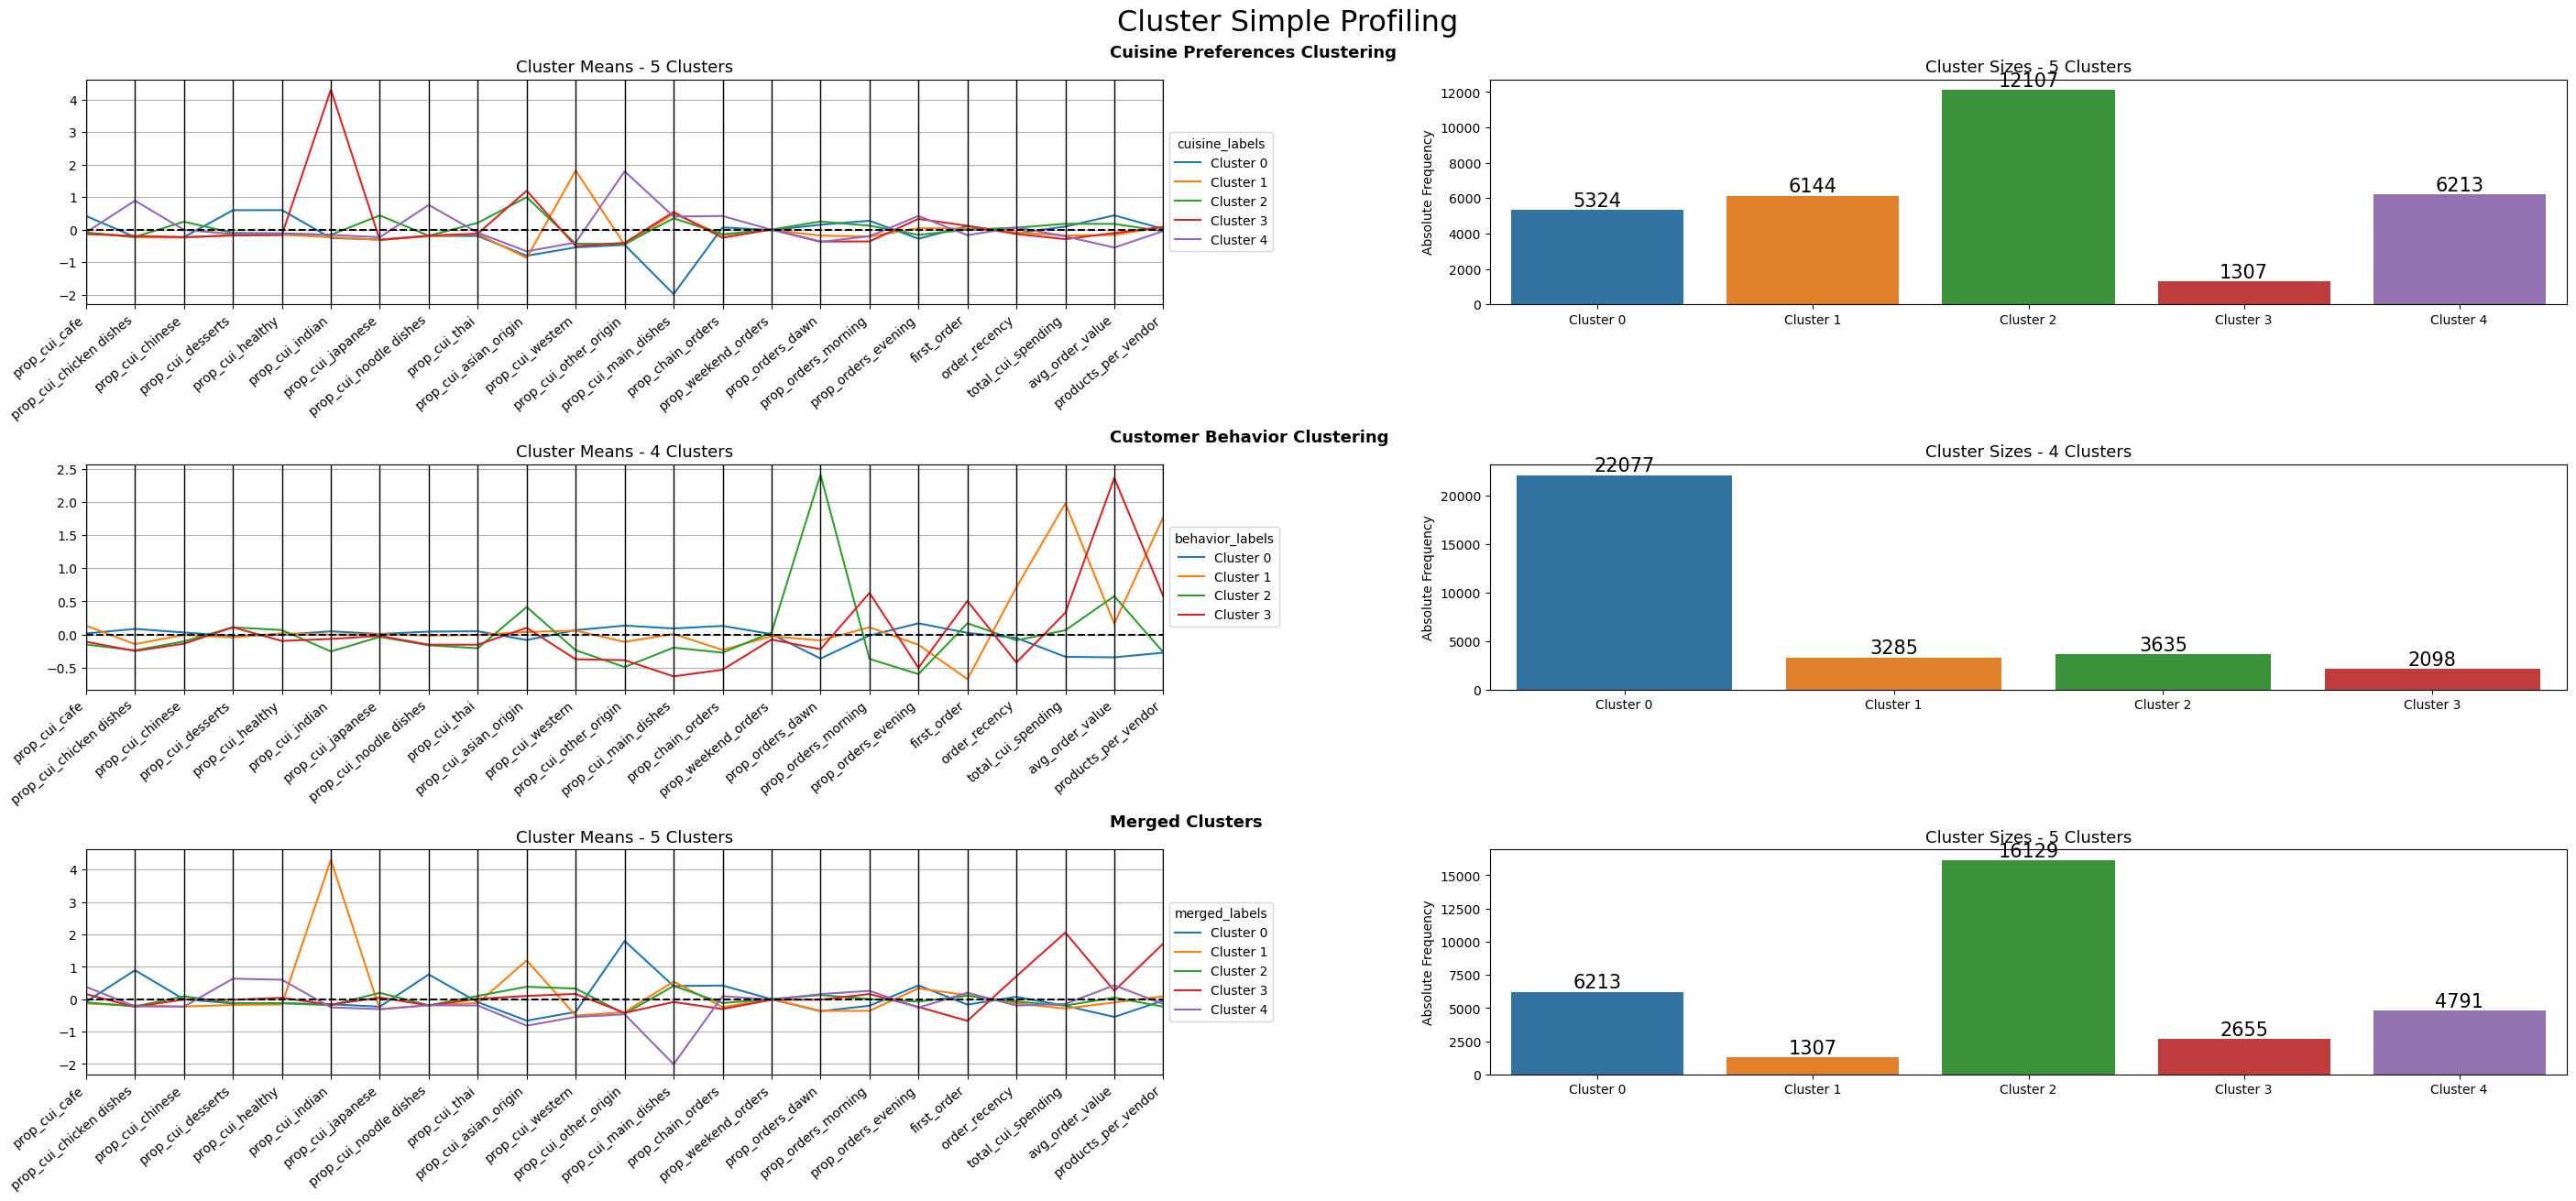

In [52]:
# Profiling each cluster (cuisine preferences, customer behavior, merged)
cluster_profiles(
    df = df_[cuisine_preferences + customer_behavior + ['cuisine_labels', 'behavior_labels', 'merged_labels']], 
    label_columns = ['cuisine_labels', 'behavior_labels', 'merged_labels'], 
    figsize = (28, 13), 
    compare_titles = ["Cuisine Preferences Clustering", "Customer Behavior Clustering", "Merged Clusters"]
)

The dominant cluster could be the result of it representing an "average" customer, as this cluster may encompass the most common behaviors or characteristics in the dataset. However, to confirm this hypothesis, further exploration is needed to understand the underlying patterns and ensure that this dominance is not driven by other factors.

### 5.2.2. Heatmap <a class="anchor" id="heatmap"></a>
[Back to 5.2. Cluster Profiling](#cluster_profiling)<br>

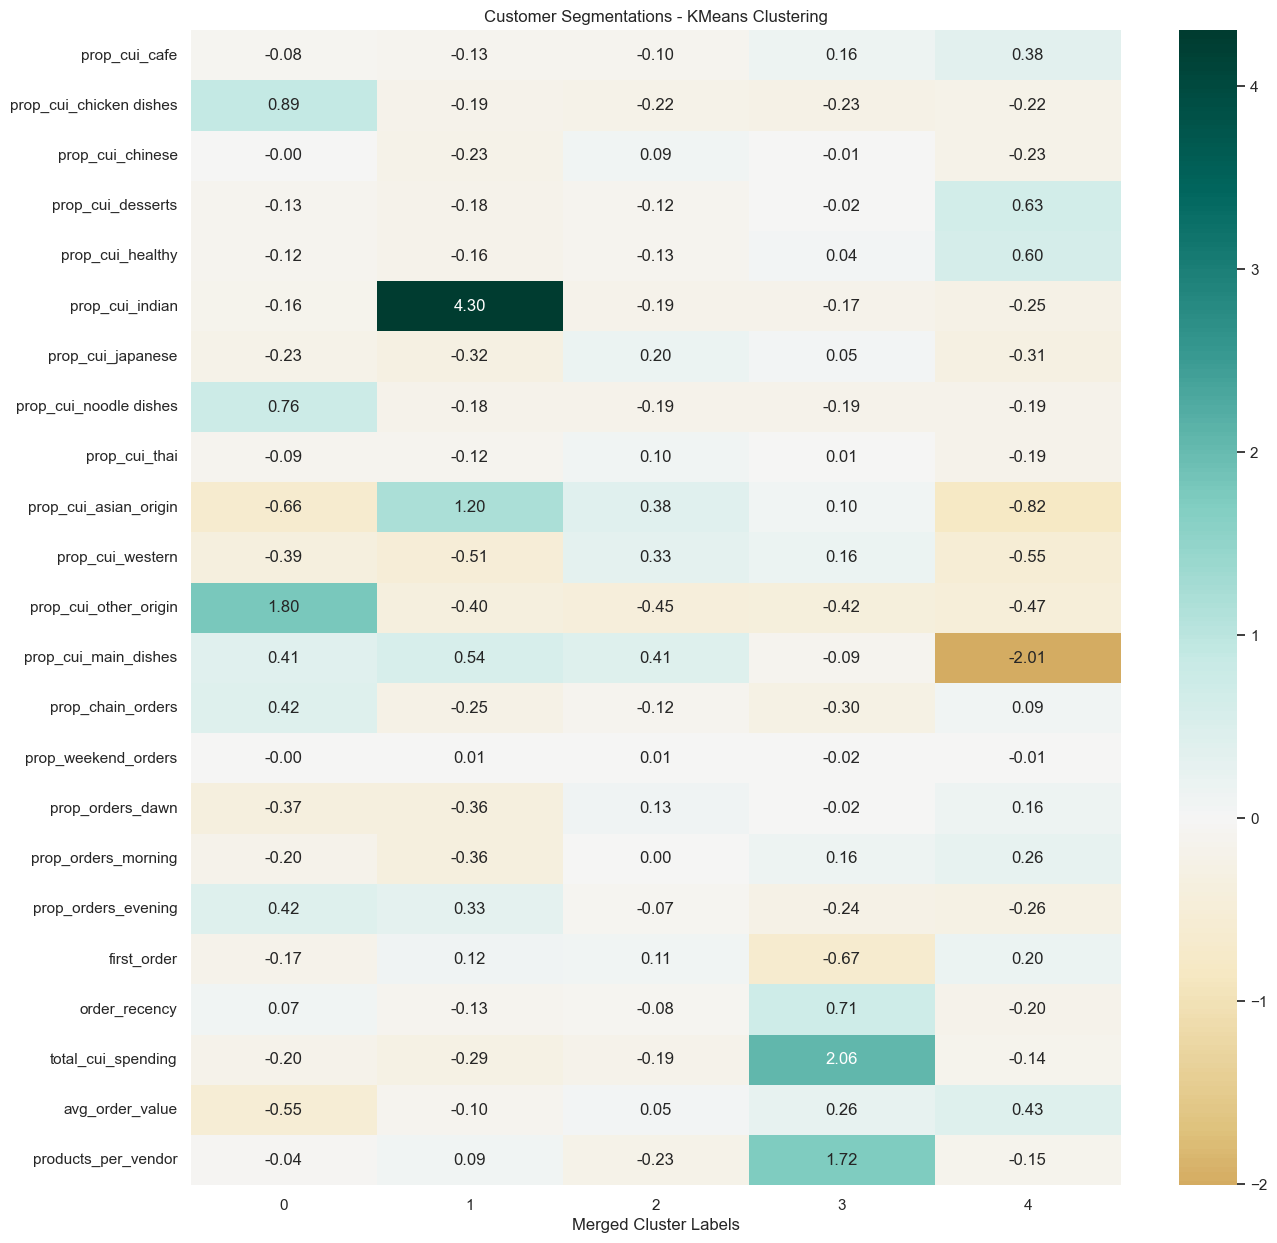

In [34]:
fig, ax = plt.subplots(figsize=(15,15))

km_profile = df_.groupby('merged_labels').mean(numeric_only=True)[cuisine_preferences + customer_behavior].T

sns.heatmap(km_profile,
            center=0, annot=True, cmap="BrBG", fmt=".2f",
            ax=ax 
            )

ax.set_xlabel("Merged Cluster Labels")
ax.set_title("Customer Segmentations - KMeans Clustering")
plt.show()

### 5.2.3. Radar Plots <a class="anchor" id="radar_plots"></a>
[Back to 5.2. Cluster Profiling](#cluster_profiling)<br>

> #### Cuisine Features
To gain deeper insights into how different cuisines are represented across the `merged_labels` clusters, we can analyze the mean values of the `prop_cui_` features for each cluster. This allows us to identify patterns or preferences in cuisine consumption among the clusters. Additionally, radar plots provide a visual representation of these patterns, helping to better compare and interpret the behavior of cuisines across clusters. By combining numerical analysis and visualizations, we can uncover meaningful insights into the data.

In [84]:
prop_cui_columns = [col for col in df_profiling_unscaled.columns if "prop_cui" in col.lower()]

In [85]:
# Calculate the overall mean for each CUI column
overall_avg = df_profiling_unscaled[prop_cui_columns].mean()

# Group by 'merged_labels' and get the mean for each CUI column
grouped_means_cui = df_profiling_unscaled.groupby('merged_labels')[prop_cui_columns].mean().T

# Add the overall averages as a new column
grouped_means_cui['Overall_Avg'] = overall_avg

# Display the final result
grouped_means_cui

merged_labels,0,1,2,3,4,Overall_Avg
prop_cui_american,0.064834,0.031144,0.208355,0.142292,0.038965,0.140490
prop_cui_asian,0.035544,0.016969,0.324000,0.265417,0.055349,0.207065
prop_cui_beverages,0.035072,0.009439,0.023536,0.047814,0.297586,0.069546
prop_cui_cafe,0.007833,0.003014,0.006245,0.029680,0.050390,0.015229
prop_cui_chicken dishes,0.165213,0.009016,0.004170,0.002641,0.004538,0.036477
prop_cui_chinese,0.041561,0.006576,0.055711,0.040697,0.006394,0.041938
prop_cui_desserts,0.007358,0.001991,0.008422,0.020039,0.094801,0.022240
prop_cui_healthy,0.010273,0.005236,0.009600,0.030312,0.099024,0.025098
prop_cui_indian,0.022388,0.827219,0.017060,0.020282,0.005075,0.050606
prop_cui_italian,0.036508,0.030837,0.144344,0.152637,0.008440,0.097795


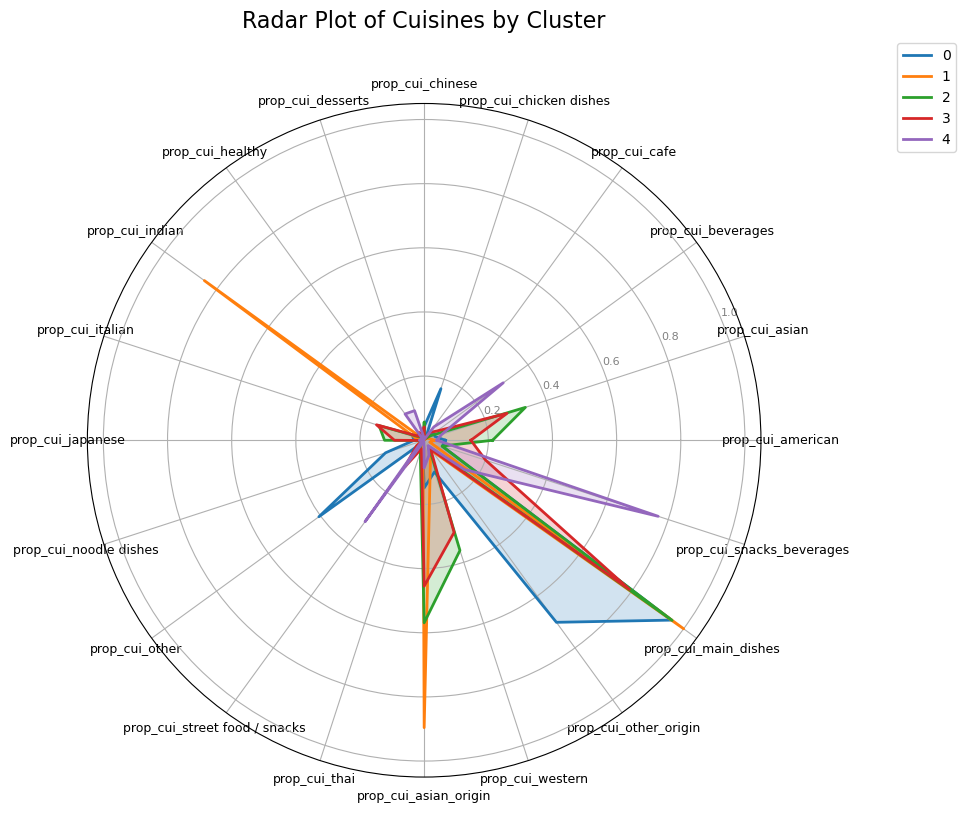

In [88]:
plot_radar(grouped_means_cui, title="Radar Plot of Cuisines by Cluster", rotation=45)

> #### Order Related Features
To gain deeper insights into how different cuisines are represented across the `merged_labels` clusters, we can analyze the mean values of the order related features for each cluster. This allows us to identify patterns or preferences in order consumption among the clusters. Additionally, radar plots provide a visual representation of these patterns, helping to better compare and interpret the behavior of orders across clusters. By combining numerical analysis and visualizations, we can uncover meaningful insights into the data.

In [90]:
#Get the list with the cui columns
order_columns = [
    col for col in df_profiling_unscaled.filter(like="order", axis=1).columns.tolist() 
    if not col.lower().startswith("orders_") 
    and "weekend_" not in col.lower() 
    and "weekday_" not in col.lower()
]

In [92]:
# Calculate the overall mean for each order_columns
overall_avg = df_profiling_unscaled[order_columns].mean()

# Group by 'merged_labels' and get the mean for each order_columns
grouped_means_orders = df_profiling_unscaled.groupby('merged_labels')[order_columns].mean().T

# Add the overall averages as a new column
grouped_means_orders['Overall_Avg'] = overall_avg

# Display the final result
grouped_means_orders

merged_labels,0,1,2,3,4,Overall_Avg
chain_orders,4.298728,1.967100,1.964412,6.183804,1.900647,2.781380
first_order,24.368743,31.305279,30.922748,12.287006,33.194740,28.388165
last_order,65.400451,60.661821,61.906132,80.070433,59.093509,63.669593
total_orders,5.417673,3.414690,3.219046,11.335217,2.757044,4.288374
order_recency,0.726672,0.674020,0.687846,0.889671,0.656595,0.707440
avg_daily_orders,0.060196,0.037941,0.035767,0.125947,0.030634,0.047649
avg_order_value,6.162466,9.441818,10.540633,12.089318,13.315885,10.179491
prop_chain_orders,0.791739,0.533226,0.582002,0.511069,0.664311,0.628484
prop_orders_dawn,0.016375,0.019233,0.150349,0.111858,0.157889,0.115944
prop_orders_morning,0.203634,0.149605,0.273074,0.326620,0.360401,0.272037


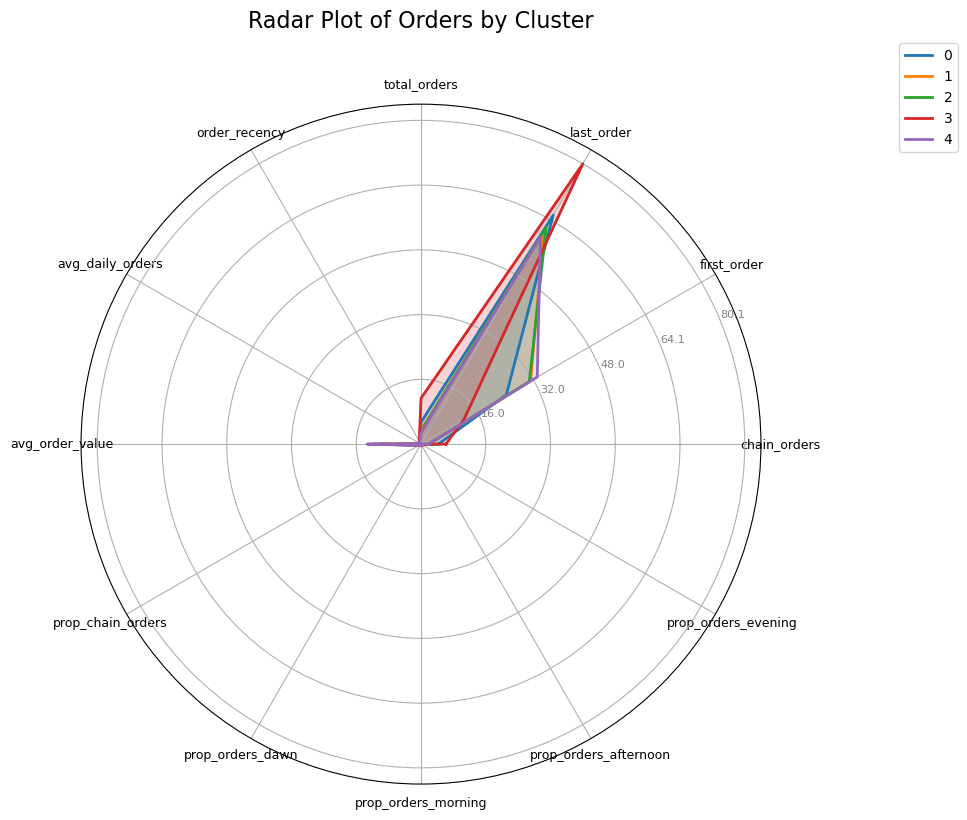

In [93]:
plot_radar(grouped_means_orders, title="Radar Plot of Orders by Cluster", rotation=45)

The prop_ features appear to have minimal impact on the analysis. Therefore, we will exclude them from the grouped_means_orders DataFrame before proceeding with further visualizations or analysis. This will help streamline the focus on more impactful features.

In [98]:
# Ensure column names are strings
grouped_means_orders.columns = grouped_means_orders.columns.astype(str)

# Exclude columns starting with 'prop_' from grouped_means_orders
grouped_means_orders_filtered = grouped_means_orders.loc[
    :, ~grouped_means_orders.columns.str.startswith('prop_')
]

# Display the updated DataFrame
grouped_means_orders_filtered.head()

merged_labels,0,1,2,3,4,Overall_Avg
chain_orders,4.298728,1.967100,1.964412,6.183804,1.900647,2.781380
first_order,24.368743,31.305279,30.922748,12.287006,33.194740,28.388165
last_order,65.400451,60.661821,61.906132,80.070433,59.093509,63.669593
total_orders,5.417673,3.414690,3.219046,11.335217,2.757044,4.288374
order_recency,0.726672,0.674020,0.687846,0.889671,0.656595,0.707440


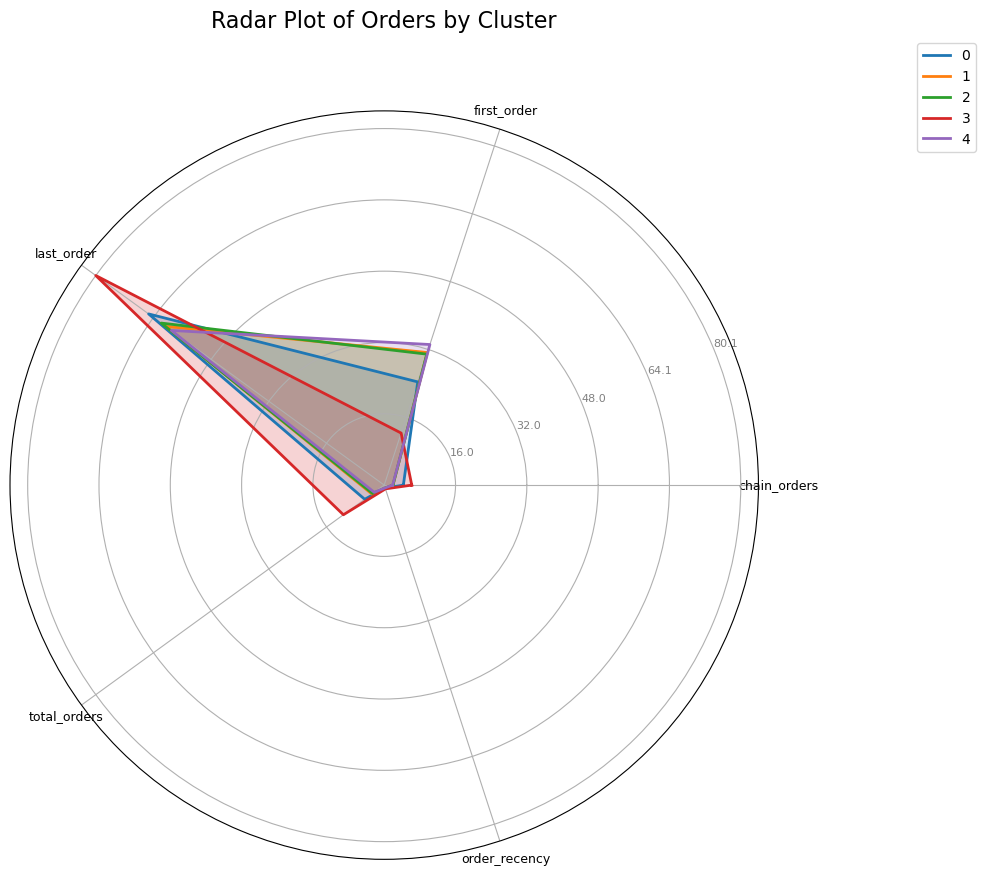

In [99]:
plot_radar(grouped_means_orders_filtered.head(), title="Radar Plot of Orders by Cluster", rotation=45)

## 5.3. Cluster Visualizations  <a class="anchor" id="cluster_visualization"></a>
[Back to 5. Cluster Analysis](#cluster_analysis)<br>

In this section, we will utilize dimensionality reduction techniques, including t-SNE, UMAP, and PCA, to better visualize the dispersion of our clusters. Additionally, we will examine the distribution of clusters with respect to the RFM features (Recency, Frequency, and Monetary) to gain deeper insights into customer behavior.

> #### T-SNE, UMAP and PCA

In [105]:
cluster_vis_features = loaded_categories['cuisine_preferences'] + loaded_categories['customer_behavior']
cluster_vis_features = cluster_vis_features + ['merged_labels']
df_cluster_visualization = df_profiling[cluster_vis_features]

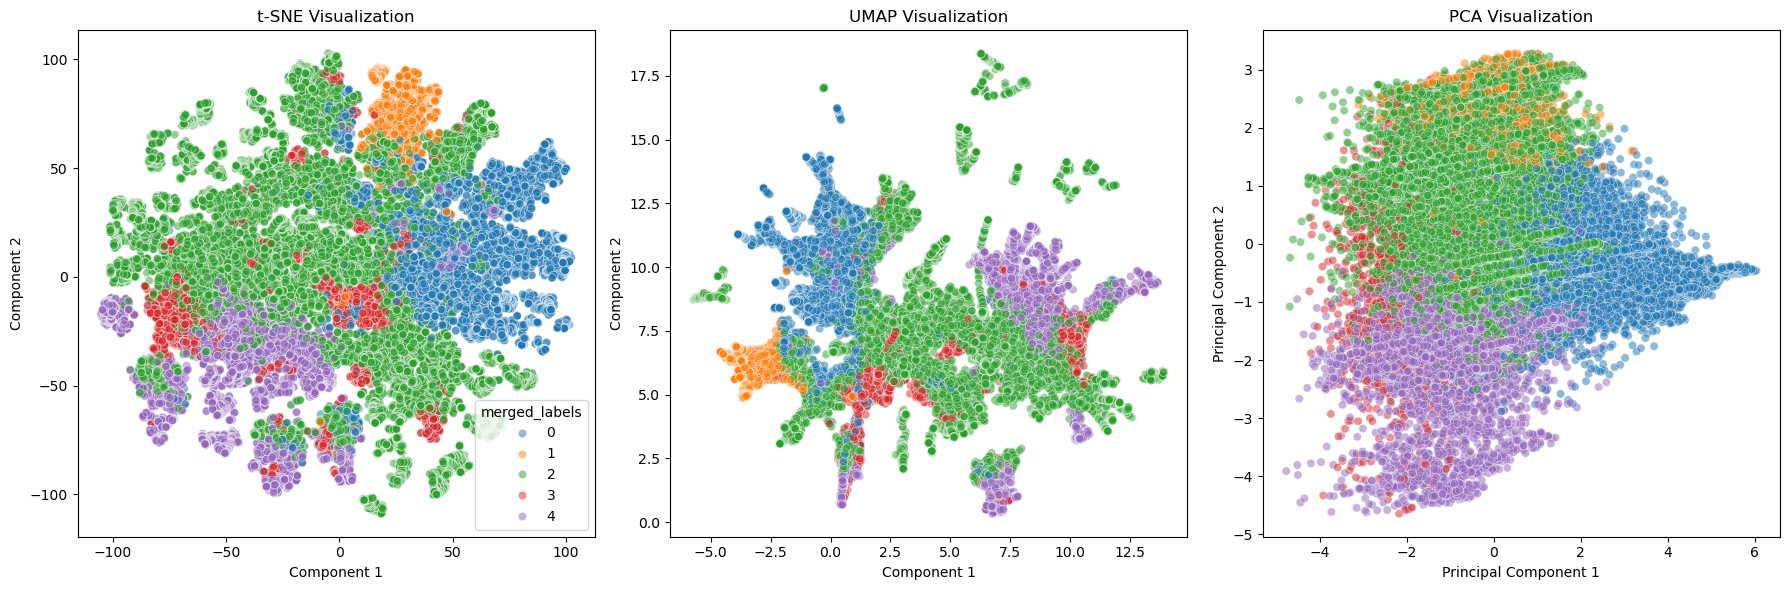

In [106]:
plot_dim_reduction(df_cluster_visualization, 'merged_labels')

> #### RFM

RFM (Recency, Frequency, and Monetary) analysis is a customer segmentation technique that evaluates customer behavior based on three dimensions:
1. **Recency (R)**: How recently a customer made a purchase. More recent activity indicates a higher likelihood of engagement.
   - **Feature**: `order_recency`
   - **Description**: Time since the customer's last order, identifying recent engagement.

2. **Frequency (F)**: How often a customer makes purchases. Frequent customers are more likely to be loyal.
   - **Feature**: `total_orders`
   - **Description**: Total number of orders placed, measuring customer activity.

3. **Monetary (M)**: How much money a customer spends. Higher spending reflects greater customer value.
   - **Feature**: `total_cui_spending`
   - **Description**: Total spending by the customer, reflecting their monetary contribution.

These features allow us to evaluate customer behavior and create actionable clusters to target specific segments for personalized strategies.


In [111]:
# Compute RFM Features
rfm_data = df_profiling_unscaled[['order_recency', 'total_orders', 'total_cui_spending', 'merged_labels']]
rfm_data.head()

,order_recency,total_orders,total_cui_spending,merged_labels
customer_id,,,,
1b8f824d5e,0.011111,2.0,28.88,1
f6d1b2ba63,0.011111,2.0,9.20,2
180c632ed8,0.022222,2.0,31.56,1
4eb37a6705,0.022222,2.0,55.44,2
6aef2b6726,0.022222,2.0,24.92,2


In [112]:
# Binning Recency, Frequency, and Monetary
# Use quartiles to segment R, F, and M values
M_segmentation = pd.qcut(rfm_data['total_cui_spending'], q=3, labels=False) + 1  # High = high value
R_segmentation = pd.qcut(rfm_data['order_recency'], q=3, labels=False) + 1  # Recent = better
F_segmentation = pd.qcut(rfm_data['total_orders'], q=3, labels=False) + 1  # High = frequent

# Combine into RFM Segmentation DataFrame
rfm_segmentation = pd.DataFrame({
    'Monetary': M_segmentation,
    'Recency': R_segmentation,
    'Frequency': F_segmentation,
    'Cluster': rfm_data['merged_labels'],
    'Monetary_Value': rfm_data['total_cui_spending'],
    'Customer_Recency': rfm_data['order_recency'],
    'Customer_Frequency': rfm_data['total_orders']
})

# Create RFM Segment Labels
rfm_segmentation['Segment'] = (
    rfm_segmentation['Recency'].astype(str)
    + "-" + rfm_segmentation['Frequency'].astype(str)
    + "-" + rfm_segmentation['Monetary'].astype(str)
)

In [119]:
#Group by Cluster and Segment
rfm_segmentation_grouped = rfm_segmentation.groupby(['Cluster']).agg({
    'Monetary_Value': 'mean',
    'Customer_Recency': 'mean',
    'Customer_Frequency': 'mean'
}).reset_index()

rfm_segmentation_grouped

,Cluster,Monetary_Value,Customer_Recency,Customer_Frequency
0,0,28.840483,0.726672,5.417673
1,1,25.838420,0.674020,3.414690
2,2,29.196972,0.687846,3.219046
3,3,108.803298,0.889671,11.335217
4,4,30.930485,0.656595,2.757044


# 6. Reclassify Outliers <a class="anchor" id="reclassify_outliers"></a>
[Back to ToC](#toc)<br>

Reintroduce outliers and predict their cluster belonging using DecisionTrees

In [120]:
df_feature_importance = df_profiling.copy()

In [121]:
# Preparing the data
X = df_feature_importance[cuisine_preferences + customer_behavior]
y = df_feature_importance.merged_labels

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Fitting the decision tree
dt = DecisionTreeClassifier(random_state=42, max_depth=3)
dt.fit(X_train, y_train)
print("It is estimated that in average, we are able to predict {0:.2f}% of the customers correctly".format(dt.score(X_test, y_test)*100))

It is estimated that in average, we are able to predict 88.81% of the customers correctly


In [122]:
# Assessing feature importance
pd.Series(dt.feature_importances_, index=X_train.columns).sort_values(ascending=False)

prop_cui_other_origin      0.440043
prop_cui_main_dishes       0.392581
prop_cui_indian            0.140283
total_cui_spending         0.025235
prop_cui_asian_origin      0.001859
prop_chain_orders          0.000000
avg_order_value            0.000000
order_recency              0.000000
first_order                0.000000
prop_orders_evening        0.000000
prop_orders_morning        0.000000
prop_orders_dawn           0.000000
prop_weekend_orders        0.000000
prop_cui_cafe              0.000000
prop_cui_chicken dishes    0.000000
prop_cui_western           0.000000
prop_cui_thai              0.000000
prop_cui_noodle dishes     0.000000
prop_cui_japanese          0.000000
prop_cui_healthy           0.000000
prop_cui_desserts          0.000000
prop_cui_chinese           0.000000
products_per_vendor        0.000000
dtype: float64

In [124]:
scaler = StandardScaler()
df_outliers_scaled = df_outliers.copy()
# Normalize the data but only for the features used in clustering
df_outliers_scaled[cuisine_preferences + customer_behavior] = scaler.fit_transform(df_outliers[cuisine_preferences + customer_behavior])

In [125]:
df_outliers_scaled[cuisine_preferences + customer_behavior].head()

,prop_cui_cafe,prop_cui_chicken dishes,prop_cui_chinese,prop_cui_desserts,prop_cui_healthy,prop_cui_indian,prop_cui_japanese,prop_cui_noodle dishes,prop_cui_thai,prop_cui_asian_origin,...,prop_chain_orders,prop_weekend_orders,prop_orders_dawn,prop_orders_morning,prop_orders_evening,first_order,order_recency,total_cui_spending,avg_order_value,products_per_vendor
customer_id,,,,,,,,,,,,,,,,,,,,,
7b0661a6ba,-0.238856,-0.160526,-0.280846,-0.153006,-0.194404,5.083814,-0.301241,-0.138449,-0.23367,1.641101,...,1.589209,0.401084,-0.441438,0.901892,-0.178993,-0.702982,-2.366468,-1.227550,-1.070071,1.054683
249ba584d3,-0.158254,-0.160526,-0.280846,-0.153006,-0.194404,-0.254766,-0.301241,-0.138449,-0.23367,1.609662,...,-0.658721,-0.068022,-0.441438,-0.855825,-0.518361,-0.702982,-0.527331,3.172871,-0.398420,1.604477
61327c3c6c,3.187020,-0.160526,-0.280846,-0.153006,-0.194404,-0.123498,0.346508,-0.138449,-0.23367,0.006435,...,0.646754,0.515190,-0.441438,0.166104,0.725987,-0.702982,-0.264597,0.891892,-0.692646,-0.681508
0df875b8cf,-0.238856,-0.160526,-0.280846,-0.153006,-0.194404,-0.254766,0.063817,-0.138449,-0.23367,-0.759433,...,-1.049665,0.515190,-0.441438,-0.643263,1.744091,-0.702982,-0.001863,-0.680347,-0.873162,0.418080
f11fd892ac,-0.238856,-0.160526,-0.033177,-0.153006,3.120096,-0.254766,-0.141384,-0.138449,-0.23367,-0.156357,...,-0.090074,0.867884,0.986993,0.507242,-0.518361,-0.702982,0.063820,0.911096,-0.533444,-0.926890


In [126]:
# Predicting the cluster labels of the outliers
df_outliers_scaled['merged_labels'] = dt.predict(df_outliers_scaled[cuisine_preferences + customer_behavior])
df_outliers_scaled.head()

,customer_region,customer_age,vendor_count,product_count,chain_orders,first_order,last_order,last_promo,payment_method,CUI_American,...,prop_cui_snacks_beverages,prop_chain_orders,prop_weekend_orders,prop_weekday_orders,prop_orders_dawn,prop_orders_morning,prop_orders_afternoon,prop_orders_evening,products_per_vendor,merged_labels
customer_id,,,,,,,,,,,,,,,,,,,,,
7b0661a6ba,2360,30,1,19,14,-0.702982,43,FREEBIE,CARD,0.00,...,0.000000,1.589209,0.401084,0.642857,-0.441438,0.901892,0.285714,-0.178993,1.054683,1
249ba584d3,4660,34,4,95,8,-0.702982,71,NOPROMO,CARD,0.00,...,0.010002,-0.658721,-0.068022,0.740741,-0.441438,-0.855825,0.925926,-0.518361,1.604477,2
61327c3c6c,4660,39,16,64,27,-0.702982,75,NOPROMO,CARD,13.01,...,0.425102,0.646754,0.515190,0.619048,-0.441438,0.166104,0.333333,0.725987,-0.681508,2
0df875b8cf,4140,21,2,27,0,-0.702982,79,NOPROMO,CARD,0.00,...,0.000000,-1.049665,0.515190,0.619048,-0.441438,-0.643263,0.380952,1.744091,0.418080,2
f11fd892ac,8670,26,25,47,12,-0.702982,80,DELIVERY,CARD,12.77,...,0.413334,-0.090074,0.867884,0.545455,0.986993,0.507242,0.151515,-0.518361,-0.926890,2


In [127]:
df_outliers_scaled['merged_labels'].value_counts()

merged_labels
2    80
4    35
0    20
1     5
3     1
Name: count, dtype: int64

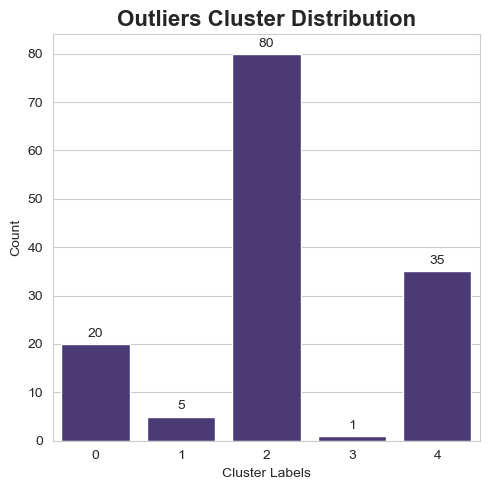

In [130]:
# Using the plot_distribution function to create the plot for outliers and cluster labels
plot_distribution(
    data=df_outliers_scaled,
    x='merged_labels',
    plot_type='count',
    title='Outliers Cluster Distribution',
    xlabel='Cluster Labels',
    ylabel='Count',
    show_counts=True,
    figsize=(5, 5),
    color_palette='viridis'  # Optional, can set a custom palette
)


# 7. Exporting Dataset <a class="anchor" id="exp_data"></a>
[Back to ToC](#toc)<br>

In this final section, we will load the unscaled final dataset, complete with the final labels, to utilize in the Bonus Point delivery.

In [134]:
df_profiling_unscaled.shape

(31095, 104)

In [135]:
df_outliers_scaled.shape

(141, 102)

In [136]:
# Remove unwanted columns from df_profiling_unscaled
df_profiling_unscaled = df_profiling_unscaled.drop(columns=['behavior_labels', 'cuisine_labels'], errors='ignore')

# Print the shape of df_profiling_unscaled
print(f"Shape of df_profiling_unscaled after dropping columns: {df_profiling_unscaled.shape}")

# Reverse scaling of df_outliers_scaled
# Create a new DataFrame to store the unscaled data
df_outliers_unscaled = df_outliers_scaled.copy()

# Reverse the scaling for the features used in clustering
df_outliers_unscaled[cuisine_preferences + customer_behavior] = scaler.inverse_transform(
    df_outliers_scaled[cuisine_preferences + customer_behavior]
)

# Print the shape of df_outliers_unscaled
print(f"Shape of df_outliers_unscaled after reversing scaling: {df_outliers_unscaled.shape}")

# Append rows from df_outliers_unscaled to df_profiling_unscaled
# Ensure both datasets have the same structure and preserve the original index
df_combined = pd.concat([df_profiling_unscaled, df_outliers_unscaled])

# Print the shape of the final combined DataFrame
print(f"Shape of df_combined after merging: {df_combined.shape}")


Shape of df_profiling_unscaled after dropping columns: (31095, 102)
Shape of df_outliers_unscaled after reversing scaling: (141, 102)
Shape of df_combined after merging: (31236, 102)
